<a href="https://colab.research.google.com/github/Gab2697/Surface-classification-EMG/blob/main/Pre_processing_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code description: 

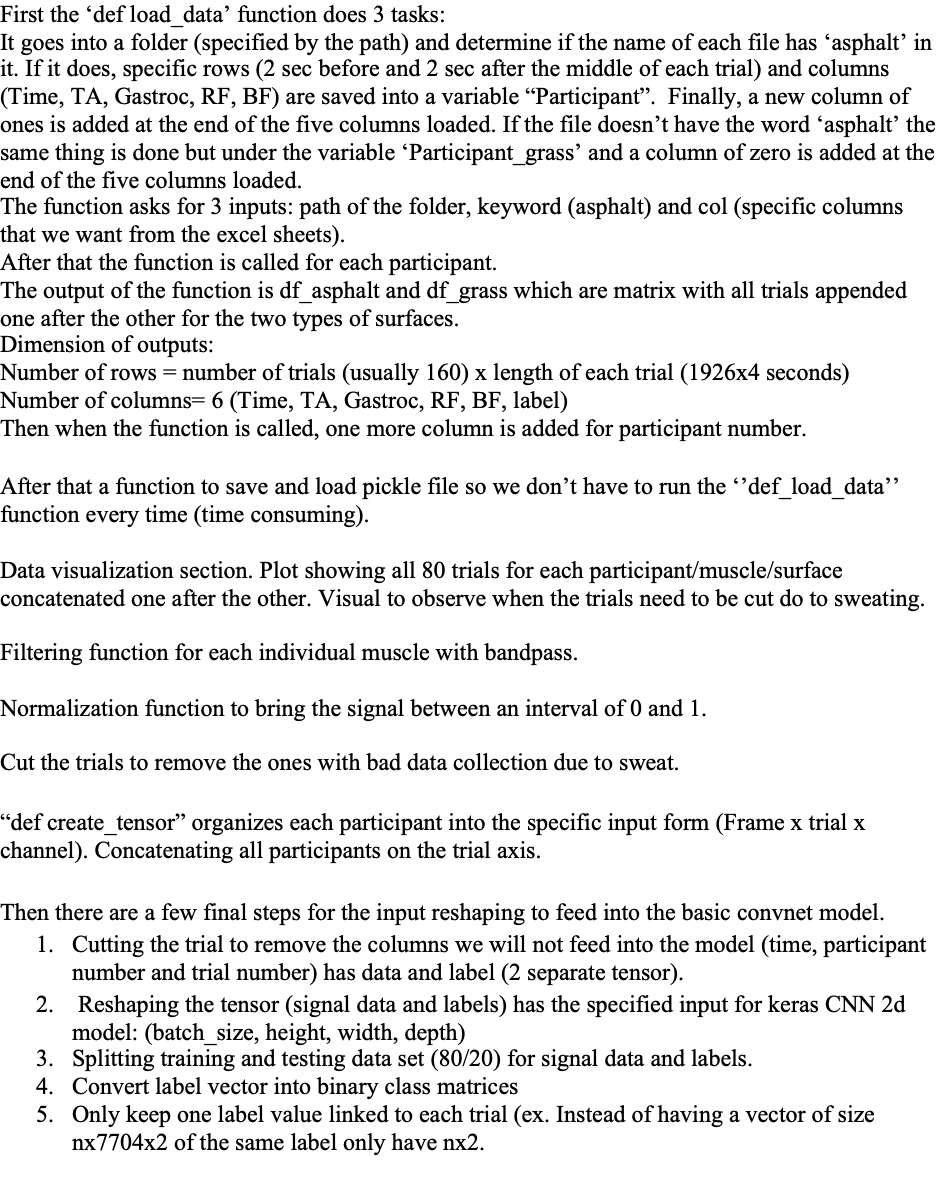

Import

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy import signal
import torch

Connect to google drive content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Participants from computer

In [ ]:
from google.colab import files 
data_to_load = files.upload()

Saving exported-27.zip to exported-27.zip


##All functions

In [ ]:
#================================Function to load data from excel================================
#organize it by surface and add a specifique label depending on the name of the excel file
def load_data(path,keyword,col):
    Window=1926*2 
    df_asphalt = pd.DataFrame()
    df_grass = pd.DataFrame()
    for fname in os.listdir(path):
      if keyword in fname: 
        os.chdir(path)
        pd_xl_file = pd.ExcelFile(fname)
        df = pd_xl_file.parse("Sheet1") 
        dimensions = df.shape
        Middle=int(dimensions[0]/2)
        Participant=pd.read_excel(fname,sheet_name='Sheet1',  usecols = col)
        Participant['label'] = pd.DataFrame(np.ones(dimensions[0]),dtype=int)
        Participant=Participant.iloc[Middle-Window:Middle+Window]
        df_asphalt = df_asphalt.append(Participant)
        
      else:
        os.chdir(path)
        pd_xl_file_grass = pd.ExcelFile(fname)
        df2 = pd_xl_file_grass.parse("Sheet1") 
        dimensions_grass = df2.shape
        Middle_grass=int(dimensions_grass[0]/2)
        Participant_grass=pd.read_excel(fname,sheet_name='Sheet1', usecols = col)
        Participant_grass['label'] = pd.DataFrame(np.zeros(dimensions_grass[0]),dtype=int)
        Participant_grass=Participant_grass.iloc[Middle_grass-Window:Middle_grass+Window]
        df_grass = df_grass.append(Participant_grass)
        
    return df_asphalt, df_grass

#================================Save pickle file================================
def save_pickle(path_pickle,T):
    f = open(path_pickle, 'wb')
    pickle.dump(T, f)
    f.close()

    return f 

#================================Open pickle file================================
def open_pickle(path_pickle):
    f = open(path_pickle, 'rb')
    T = pickle.load(f)
    f.close()

    return T

#================================Filter signal-bandpass================================
def filteremg(emg, Fs=1926, high_band=20, low_band=500):
    #variables
    time=emg.iloc[:,0]
    TA=emg.iloc[:,1]
    Gastroc=emg.iloc[:,2]
    RF=emg.iloc[:,3]
    BF=emg.iloc[:,4]
  
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(Fs/2)
    low_band = low_band/(Fs/2)
    
    # create bandpass filter for EMG
    b1, a1 = signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filt_TA = signal.filtfilt(b1, a1, TA)
    emg_filt_Gastroc= signal.filtfilt(b1, a1, Gastroc) 
    emg_filt_RF = signal.filtfilt(b1, a1, RF) 
    emg_filt_BF = signal.filtfilt(b1, a1, BF)

    #label and participant number
    label=np.transpose([emg.iloc[:,5]])
    Part_number=np.transpose([emg.iloc[:,6]])    

    return emg_filt_TA,emg_filt_Gastroc,emg_filt_RF,emg_filt_BF,label,Part_number

#================================Normalize data================================

def normalize(x):
    #Normalized Data
    TA_norm = (x[0]-min(x[0]))/(max(x[0])-min(x[0]))
    Gastroc_norm = (x[1]-min(x[1]))/(max(x[1])-min(x[1]))
    RF_norm = (x[2]-min(x[2]))/(max(x[2])-min(x[2]))
    BF_norm = (x[3]-min(x[3]))/(max(x[3])-min(x[3]))
    
    #label and participant number
    label=x[4]
    Part_number=x[5]
    return TA_norm,Gastroc_norm,RF_norm,BF_norm,label,Part_number

"""
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

TA_normalized=feature_normalize(TA_filt)
plt.plot(TA_normalized)
"""

#================================Cut sweat trials================================
def cut_sweat_no_interv(idx_gTA,idx_gG,idx_gRF,idx_gBF,idx_aTA,idx_aG,idx_aRF,idx_aBF,df_grass_norm,df_asphalt_norm):
    df_grass_cut_TA=df_grass_norm.iloc[idx_gTA,0]
    df_grass_cut_Gas=df_grass_norm.iloc[idx_gG,1]
    df_grass_cut_RF=df_grass_norm.iloc[idx_gRF,2]
    df_grass_cut_BF=df_grass_norm.iloc[idx_gBF,3]
    df_grass_cut=pd.DataFrame([df_grass_cut_TA,df_grass_cut_Gas, df_grass_cut_RF,df_grass_cut_BF,df_grass_norm[4],df_grass_norm[5]])
    df_grass_cut=(df_grass_cut.fillna(0)).T
    df_asphalt_cut_TA=df_asphalt_norm.iloc[idx_aTA,0]
    df_asphalt_cut_Gas=df_asphalt_norm.iloc[idx_aG,1]
    df_asphalt_cut_RF=df_asphalt_norm.iloc[idx_aRF,2]
    df_asphalt_cut_BF=df_asphalt_norm.iloc[idx_aBF,3]
    df_asphalt_cut=pd.DataFrame([df_asphalt_cut_TA,df_asphalt_cut_Gas, df_asphalt_cut_RF,df_asphalt_cut_BF,df_asphalt_norm[4],df_asphalt_norm[5]])
    df_asphalt_cut=(df_asphalt_cut.fillna(0)).T
    
    return df_grass_cut, df_asphalt_cut

#================================Creating tensor with specific shape================================
def create_tensor(df_a,df_g):
    #tensor asphalt 
    trials_a=len(df_a)/(1926*4) # how many trials-80
    T_asphalt=np.stack(np.split(df_a.values, trials_a), axis=1)
    #tensor grass
    trials_g=len(df_g)/(1926*4) # how many trials
    T_grass=np.stack(np.split(df_g.values, trials_g), axis=1)
    #tensor both conditions
    a=tf.constant(T_asphalt.astype('float32'))
    g=tf.constant(T_grass.astype('float32'))
    T = tf.concat([a, g], axis=1)

    return T

#Prepare the data

Unzip file and remove the bad files created (._)

In [ ]:
#only do once
# !unzip "/content/drive/MyDrive/Gab/Participants/P20/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P20"
# !unzip "/content/drive/MyDrive/Gab/Participants/P24/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P24"
#only do once (2,4,8,10,11,12)
# !unzip "/content/drive/MyDrive/Gab/Participants/P02/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P02"
# !unzip "/content/drive/MyDrive/Gab/Participants/P04/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P04"
# !unzip "/content/drive/MyDrive/Gab/Participants/P08/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P08"
# !unzip "/content/drive/MyDrive/Gab/Participants/P10/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P10"
# !unzip "/content/drive/MyDrive/Gab/Participants/P11/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P11"
# !unzip "/content/drive/MyDrive/Gab/Participants/P12/exported.zip" -d "/content/drive/MyDrive/Gab/Participants/P12"

# !unzip "/content/exported-13.zip" -d "/content/"
# !unzip "/content/exported-13/exported-14.zip" -d "/content/" 
# !unzip "/content/exported-14/exported-15.zip" -d "/content/" 
# !unzip "/content/exported-14/exported-15.zip" -d "/content/"
# !unzip "/content/exported-16/exported-17.zip" -d "/content/" 
# !unzip "/content/exported-17/exported-18.zip" -d "/content/"  
# !unzip "/content/exported-18/exported-19.zip" -d "/content/" 
# !unzip "/content/exported-19/exported-21.zip" -d "/content/"  
# !unzip "/content/exported-21/exported-22.zip" -d "/content/" 
# !unzip "/content/exported-23.zip" -d "/content/" 
# !unzip "/content/exported-13/exported-15.zip" -d "/content/" 
# !unzip "/content/exported-25/exported-26.zip" -d "/content/" 
!unzip "/content/exported-27.zip" -d "/content/" 
# !unzip "/content/exported/exported-28.zip" -d "/content/" 

In [ ]:
#remove files starting with ._
import os
import glob

files = glob.glob('/content/drive/MyDrive/Gab/Participants/P41/P41/Exported/._*')
for f in files:
    os.remove(f)

Call load function and add specific columns (participant and trial number)

In [ ]:
#P02
#participant 2 there was a modification in column organisation of the excel output from sensor in the middle of the trials
path2_1= '/content/drive/MyDrive/Gab/Participants/P02/exported/Org_1/'
df_asphalt_2, df_grass_2= load_data(path2_1,'asphalt',"A,B,D,L,T")
df_asphalt_2['participant_number']=2#add column for participant number
df_grass_2['participant_number']=2#add column for participant number

path2_2= '/content/drive/MyDrive/Gab/Participants/P02/exported/Org_2'
df_asphalt_2, df_grass_2= load_data(path2_2,'asphalt',"A,B,J,R,Z")
df_asphalt_2['participant_number']=2#add column for participant number
df_grass_2['participant_number']=2#add column for participant number

In [ ]:
#P01
path1= '/content/drive/MyDrive/Gab/Participants/P01/exported-1/' 
df_asphalt_1, df_grass_1= load_data(path1,'sidewalk',"A,B,J,R,Z")
df_asphalt_1['participant_number']=1#add column for participant number
df_grass_1['participant_number']=1#add column for participant number

#P03
path3= '/content/drive/MyDrive/Gab/Participants/P03/exported-emg/'
df_asphalt_3, df_grass_3= load_data(path3,'asphalt',"A,B,D,L,T")
df_asphalt_3['participant_number']=3
df_grass_3['participant_number']=3

#P05
path5= '/content/drive/MyDrive/Gab/Participants/P05/exported-emg-5/'
df_asphalt_5, df_grass_5= load_data(path5,'asphalt',"A,B,D,L,T")
df_asphalt_5['participant_number']=5
df_grass_5['participant_number']=5

#P07
path7= '/content/drive/MyDrive/Gab/Participants/P07/exported-emg-7/'
df_asphalt_7, df_grass_7= load_data(path7,'asphalt',"A,B,D,L,T")
df_asphalt_7['participant_number']=7
df_grass_7['participant_number']=7

#P09
path9= '/content/drive/MyDrive/Gab/Participants/P09/exported-emg-9/'
df_asphalt_9, df_grass_9= load_data(path9,'asphalt',"A,B,D,L,T") 
df_asphalt_9['participant_number']=9
df_grass_9['participant_number']=9

#P20
path20= '/content/drive/MyDrive/Gab/Participants/P20/exported/'
df_asphalt_20, df_grass_20= load_data(path20,'asphalt',"A,B,D,L,T")
df_asphalt_20['participant_number']=20
df_grass_20['participant_number']=20

#P24
path24= '/content/drive/MyDrive/Gab/Participants/P24/exported/'
df_asphalt_24, df_grass_24= load_data(path24,'asphalt',"A,B,D,L,T") 
df_asphalt_24['participant_number']=24
df_grass_24['participant_number']=24

#P04
path4= '/content/drive/MyDrive/Gab/Participants/P04/exported/'
df_asphalt_4, df_grass_4= load_data(path4,'asphalt',"A,B,D,L,T") 
df_asphalt_4['participant_number']=4
df_grass_4['participant_number']=4

#P08
path8= '/content/drive/MyDrive/Gab/Participants/P08/exported/'
df_asphalt_8, df_grass_8= load_data(path8,'asphalt',"A,B,D,L,T")
df_asphalt_8['participant_number']=8
df_grass_8['participant_number']=8

#P10
path10= '/content/drive/MyDrive/Gab/Participants/P10/exported/'
df_asphalt_10, df_grass_10= load_data(path10,'asphalt',"A,B,D,L,T") 
df_asphalt_10['participant_number']=10
df_grass_10['participant_number']=10

#P11
path11= '/content/drive/MyDrive/Gab/Participants/P11/exported/'
df_asphalt_11, df_grass_11= load_data(path11,'asphalt',"A,B,D,L,T")
df_asphalt_11['participant_number']=11
df_grass_11['participant_number']=11

#P12
path12= '/content/drive/MyDrive/Gab/Participants/P12/exported/'
df_asphalt_12, df_grass_12= load_data(path12,'asphalt',"A,B,D,L,T") 
df_asphalt_12['participant_number']=12
df_grass_12['participant_number']=12

#P13
path13= '/content/exported-13'
df_asphalt_13, df_grass_13= load_data(path13,'asphalt',"A,B,D,L,T") 
df_asphalt_13['participant_number']=13
df_grass_13['participant_number']=13

#P14
path14= '/content/exported-14'
df_asphalt_14, df_grass_14= load_data(path14,'asphalt',"A,B,D,L,T") 
df_asphalt_14['participant_number']=14
df_grass_14['participant_number']=14

#P15
path15= '/content/exported-15'
df_asphalt_15, df_grass_15= load_data(path15,'asphalt',"A,B,D,L,T") 
df_asphalt_15['participant_number']=15
df_grass_15['participant_number']=15

#P16
path16= '/content/exported-16'
df_asphalt_16, df_grass_16= load_data(path16,'asphalt',"A,B,D,L,T") 
df_asphalt_16['participant_number']=16
df_grass_16['participant_number']=16

#P17
path17= '/content/exported-17'
df_asphalt_17, df_grass_17= load_data(path17,'asphalt',"A,B,D,L,T") 
df_asphalt_17['participant_number']=17
df_grass_17['participant_number']=17

#P18
path18= '/content/exported-18'
df_asphalt_18, df_grass_18= load_data(path18,'asphalt',"A,B,D,L,T") 
df_asphalt_18['participant_number']=18
df_grass_18['participant_number']=18

#P19
path19= '/content/exported-19'
df_asphalt_19, df_grass_19= load_data(path19,'asphalt',"A,B,D,L,T") 
df_asphalt_19['participant_number']=19
df_grass_19['participant_number']=19

#P21
path21= '/content/exported-21'
df_asphalt_21, df_grass_21= load_data(path21,'asphalt',"A,B,D,L,T") 
df_asphalt_21['participant_number']=21
df_grass_21['participant_number']=21

#P22
path22= '/content/exported-22'
df_asphalt_22, df_grass_22= load_data(path22,'asphalt',"A,B,D,L,T") 
df_asphalt_22['participant_number']=22
df_grass_22['participant_number']=22

#P23
path23= '/content/exported-23'
df_asphalt_23, df_grass_23= load_data(path23,'asphalt',"A,B,D,L,T") 
df_asphalt_23['participant_number']=23
df_grass_23['participant_number']=23

#P25
path25= '/content/exported-25'
df_asphalt_25, df_grass_25= load_data(path25,'asphalt',"A,B,D,L,T") 
df_asphalt_25['participant_number']=25
df_grass_25['participant_number']=25

#P26
path26= '/content/exported'
df_asphalt_26, df_grass_26= load_data(path26,'asphalt',"A,B,D,L,T") 
df_asphalt_26['participant_number']=26
df_grass_26['participant_number']=26

#P27
path27= '/content/exported-27'
df_asphalt_27, df_grass_27= load_data(path27,'asphalt',"A,B,D,L,T") 
df_asphalt_27['participant_number']=27
df_grass_27['participant_number']=27

#P28
path28= '/content/exported-28'
df_asphalt_28, df_grass_28= load_data(path28,'asphalt',"A,B,D,L,T") 
df_asphalt_28['participant_number']=28
df_grass_28['participant_number']=28

In [ ]:
#P29
path29= '/content/drive/MyDrive/Gab/Participants/P29/exported/'
df_asphalt_29, df_grass_29= load_data(path29,'asphalt',"A,B,D,L,T") 
df_asphalt_29['participant_number']=29
df_grass_29['participant_number']=29

#P30
path30= '/content/drive/MyDrive/Gab/Participants/P30/exported/'
df_asphalt_30, df_grass_30= load_data(path30,'asphalt',"A,B,D,L,T") 
df_asphalt_30['participant_number']=30
df_grass_30['participant_number']=30

#P31
path31= '/content/drive/MyDrive/Gab/Participants/P31/exported/'
df_asphalt_31, df_grass_31= load_data(path31,'asphalt',"A,B,D,L,T") 
df_asphalt_31['participant_number']=31
df_grass_31['participant_number']=31

#P32
path32= '/content/drive/MyDrive/Gab/Participants/P32/Exported/'
df_asphalt_32, df_grass_32= load_data(path32,'asphalt',"A,B,D,L,T") 
df_asphalt_32['participant_number']=32
df_grass_32['participant_number']=32

#P33
path33= '/content/drive/MyDrive/Gab/Participants/P33/Exported/'
df_asphalt_33, df_grass_33= load_data(path33,'asphalt',"A,B,D,L,T") 
df_asphalt_33['participant_number']=33
df_grass_33['participant_number']=33

#P34
path34= '//content/drive/MyDrive/Gab/Participants/P34/Exported/'
df_asphalt_34, df_grass_34= load_data(path34,'asphalt',"A,B,D,L,T") 
df_asphalt_34['participant_number']=34
df_grass_34['participant_number']=34

#P35
path35= '/content/drive/MyDrive/Gab/Participants/P35/P35/Exported/'
df_asphalt_35, df_grass_35= load_data(path35,'asphalt',"A,B,D,L,T") 
df_asphalt_35['participant_number']=35
df_grass_35['participant_number']=35

#P36
path36= '/content/drive/MyDrive/Gab/Participants/P36/P36/Exported/'
df_asphalt_36, df_grass_36= load_data(path36,'asphalt',"A,B,D,L,T") 
df_asphalt_36['participant_number']=36
df_grass_36['participant_number']=36

#P37
path37= '//content/drive/MyDrive/Gab/Participants/P37/P37/Exported'
df_asphalt_37, df_grass_37= load_data(path37,'asphalt',"A,B,D,L,T") 
df_asphalt_37['participant_number']=37
df_grass_37['participant_number']=37

#P38
path38= '/content/drive/MyDrive/Gab/Participants/P38/P38/Exported'
df_asphalt_38, df_grass_38= load_data(path38,'asphalt',"A,B,D,L,T") 
df_asphalt_38['participant_number']=38
df_grass_38['participant_number']=38

#P39
path39= '/content/drive/MyDrive/Gab/Participants/P39/exported-39'
df_asphalt_39, df_grass_39= load_data(path39,'asphalt',"A,B,D,L,T") 
df_asphalt_39['participant_number']=39
df_grass_39['participant_number']=39

#P40
path40= '/content/drive/MyDrive/Gab/Participants/P40/P40/Exported'
df_asphalt_40, df_grass_40= load_data(path40,'asphalt',"A,B,D,L,T") 
df_asphalt_40['participant_number']=40
df_grass_40['participant_number']=40

#P41
path41= '/content/drive/MyDrive/Gab/Participants/P41/P41/Exported'
df_asphalt_41, df_grass_41= load_data(path41,'asphalt',"A,B,D,L,T") 
df_asphalt_41['participant_number']=41
df_grass_41['participant_number']=41

In [ ]:
#P39
path39= '/content/drive/MyDrive/Gab/Participants/P39/exported-39'
df_asphalt_39, df_grass_39= load_data(path39,'asphalt',"A,B,D,L,T") 
df_asphalt_39['participant_number']=39
df_grass_39['participant_number']=39


Save pickle files (raw, no-preprocessing steps)

In [ ]:
f2_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P02_g.pickle',df_grass_2)
f2_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P02_a.pickle',df_asphalt_2)
f7_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P07_g.pickle',df_grass_7)
f7_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P07_a.pickle',df_asphalt_7)
f9_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P09_g.pickle',df_grass_9)
f9_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P09_a.pickle',df_asphalt_9)
f20_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P20_g.pickle',df_grass_20)
f20_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P20_a.pickle',df_asphalt_20)
f24_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P24_g.pickle',df_grass_24)
f24_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P24_a.pickle',df_asphalt_24)
f4_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P04_g.pickle',df_grass_4)
f4_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P04_a.pickle',df_asphalt_4)
f8_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P08_g.pickle',df_grass_8)
f8_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P08_a.pickle',df_asphalt_8)
f10_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P10_g.pickle',df_grass_10)
f10_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P10_a.pickle',df_asphalt_10)
f11_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P11_g.pickle',df_grass_11)
f11_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P11_a.pickle',df_asphalt_11)
f12_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P12_g.pickle',df_grass_12)
f12_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P12_a.pickle',df_asphalt_12)
f13_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P13_g.pickle',df_grass_13)
f13_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P13_a.pickle',df_asphalt_13)
f14_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P14_g.pickle',df_grass_14)
f14_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P14_a.pickle',df_asphalt_14)
f15_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P15_g.pickle',df_grass_15)
f15_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P15_a.pickle',df_asphalt_15)
f16_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P16_g.pickle',df_grass_16)
f16_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P16_a.pickle',df_asphalt_16)
f17_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P17_g.pickle',df_grass_17)
f17_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P17_a.pickle',df_asphalt_17)
f18_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P18_g.pickle',df_grass_18)
f18_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P18_a.pickle',df_asphalt_18)
f19_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P19_g.pickle',df_grass_19)
f19_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P19_a.pickle',df_asphalt_19)
f21_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P21_g.pickle',df_grass_21)
f21_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P21_a.pickle',df_asphalt_21)
f22_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P22_g.pickle',df_grass_22)
f22_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P22_a.pickle',df_asphalt_22)
f23_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P23_g.pickle',df_grass_23)
f23_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P23_a.pickle',df_asphalt_23)
f25_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P25_g.pickle',df_grass_25)
f25_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P25_a.pickle',df_asphalt_25)
f26_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P26_g.pickle',df_grass_26)
f26_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P26_a.pickle',df_asphalt_26)
f27_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P27_g.pickle',df_grass_27)
f27_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P27_a.pickle',df_asphalt_27)
f28_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P28_g.pickle',df_grass_28)
f28_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P28_a.pickle',df_asphalt_28)

In [ ]:
f29_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P29_g.pickle',df_grass_29)
f29_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P29_a.pickle',df_asphalt_29)
f30_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P30_g.pickle',df_grass_30)
f30_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P30_a.pickle',df_asphalt_30)
f31_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P31_g.pickle',df_grass_31)
f31_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P31_a.pickle',df_asphalt_31)
f32_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P32_g.pickle',df_grass_32)
f32_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P32_a.pickle',df_asphalt_32)
f33_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P33_g.pickle',df_grass_33)
f33_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P33_a.pickle',df_asphalt_33)
f34_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P34_g.pickle',df_grass_34)
f34_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P34_a.pickle',df_asphalt_34)
f35_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P35_g.pickle',df_grass_35)
f35_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P35_a.pickle',df_asphalt_35)
f36_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P36_g.pickle',df_grass_36)
f36_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P36_a.pickle',df_asphalt_36)
f37_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P37_g.pickle',df_grass_37)
f37_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P37_a.pickle',df_asphalt_37)
f38_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P38_g.pickle',df_grass_38)
f38_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P38_a.pickle',df_asphalt_38)
f39_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_g.pickle',df_grass_39)
f39_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_a.pickle',df_asphalt_39)
f40_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P40_g.pickle',df_grass_40)
f40_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P40_a.pickle',df_asphalt_40)
f41_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P41_g.pickle',df_grass_41)
f41_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P41_a.pickle',df_asphalt_41)

In [ ]:
f39_g=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_g.pickle',df_grass_39)
f39_a=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_a.pickle',df_asphalt_39)

Open pickle file (raw, no-preprocessing steps)

In [ ]:
#load
df_grass_2= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P02_g.pickle')
df_asphalt_2= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P02_a.pickle')
# df_grass_3= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P03_g.pickle')
# df_asphalt_3= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P03_a.pickle')
# df_grass_5= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P05_g.pickle')
# df_asphalt_5= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P05_a.pickle')
# df_grass_7= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P07_g.pickle')
# df_asphalt_7= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P07_a.pickle')
# df_grass_9= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P09_g.pickle')
# df_asphalt_9= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P09_a.pickle')
# df_grass_20= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P20_g.pickle')
# df_asphalt_20= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P20_a.pickle')
# df_grass_24= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P24_g.pickle')
# df_asphalt_24= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P24_a.pickle')
# df_grass_4= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P04_g.pickle')
# df_asphalt_4= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P04_a.pickle')
# df_grass_8= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P08_g.pickle')
# df_asphalt_8= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P08_a.pickle')
# df_grass_10= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P10_g.pickle')
# df_asphalt_10= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P10_a.pickle')
# df_grass_11= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P11_g.pickle')
# df_asphalt_11= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P11_a.pickle')
# df_grass_12= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P12_g.pickle')
# df_asphalt_12= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P12_a.pickle')
df_grass_13= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P13_g.pickle')
df_asphalt_13= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P13_a.pickle')
df_grass_14= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P14_g.pickle')
df_asphalt_14= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P14_a.pickle')
df_grass_15= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P15_g.pickle')
df_asphalt_15= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P15_a.pickle')
df_grass_16= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P16_g.pickle')
df_asphalt_16= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P16_a.pickle')
df_grass_17= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P17_g.pickle')
df_asphalt_17= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P17_a.pickle')
df_grass_18= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P18_g.pickle')
df_asphalt_18= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P18_a.pickle')
df_grass_19= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P19_g.pickle')
df_asphalt_19= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P19_a.pickle')
df_grass_21= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P21_g.pickle')
df_asphalt_21= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P21_a.pickle')
df_grass_22= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P22_g.pickle')
df_asphalt_22= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P22_a.pickle')
df_grass_23= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P23_g.pickle')
df_asphalt_23= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P23_a.pickle')
df_grass_25= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P25_g.pickle')
df_asphalt_25= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P25_a.pickle')
df_grass_26= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P26_g.pickle')
df_asphalt_26= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P26_a.pickle')
df_grass_27= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P27_g.pickle')
df_asphalt_27= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P27_a.pickle')
df_grass_28= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P28_g.pickle')
df_asphalt_28= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P28_a.pickle')
df_grass_27= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P27_g.pickle')
df_asphalt_27= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P27_a.pickle')

In [ ]:
df_grass_29= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P29_g.pickle')
df_asphalt_29= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P29_a.pickle')
df_grass_30= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P30_g.pickle')
df_asphalt_30= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P30_a.pickle')
df_grass_31= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P31_g.pickle')
df_asphalt_31= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P31_a.pickle')
df_grass_32= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P32_g.pickle')
df_asphalt_32= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P32_a.pickle')
df_grass_33= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P33_g.pickle')
df_asphalt_33= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P33_a.pickle')
df_grass_34= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P34_g.pickle')
df_asphalt_34= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P34_a.pickle')
df_grass_35= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P35_g.pickle')
df_asphalt_35= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P35_a.pickle')
df_grass_36= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P36_g.pickle')
df_asphalt_36= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P36_a.pickle')
df_grass_37= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P37_g.pickle')
df_asphalt_37= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P37_a.pickle')
df_grass_38= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P38_g.pickle')
df_asphalt_38= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P38_a.pickle')
df_grass_39= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_g.pickle')
df_asphalt_39= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_a.pickle')
df_grass_40= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P40_g.pickle')
df_asphalt_40= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P40_a.pickle')
df_grass_41= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P41_g.pickle')
df_asphalt_41= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P41_a.pickle')

In [ ]:
df_grass_39= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_g.pickle')
df_asphalt_39= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/P39_a.pickle')

Data visualization

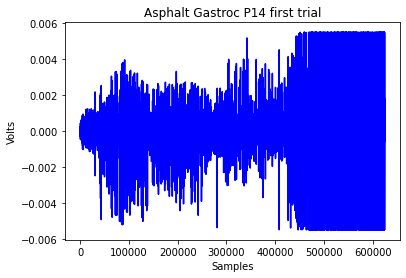

In [ ]:
#visualization of data grass
df_grass=df_asphalt_29 
len_grass= list(range(0,len(df_grass.iloc[:,0])))
plt.plot(len_grass,df_grass.iloc[: ,2],'b') 
# plt.ylim((-0.008,0.008))
plt.title('Asphalt Gastroc P14 first trial') 
plt.xlabel('Samples')
plt.ylabel('Volts')
plt.show()

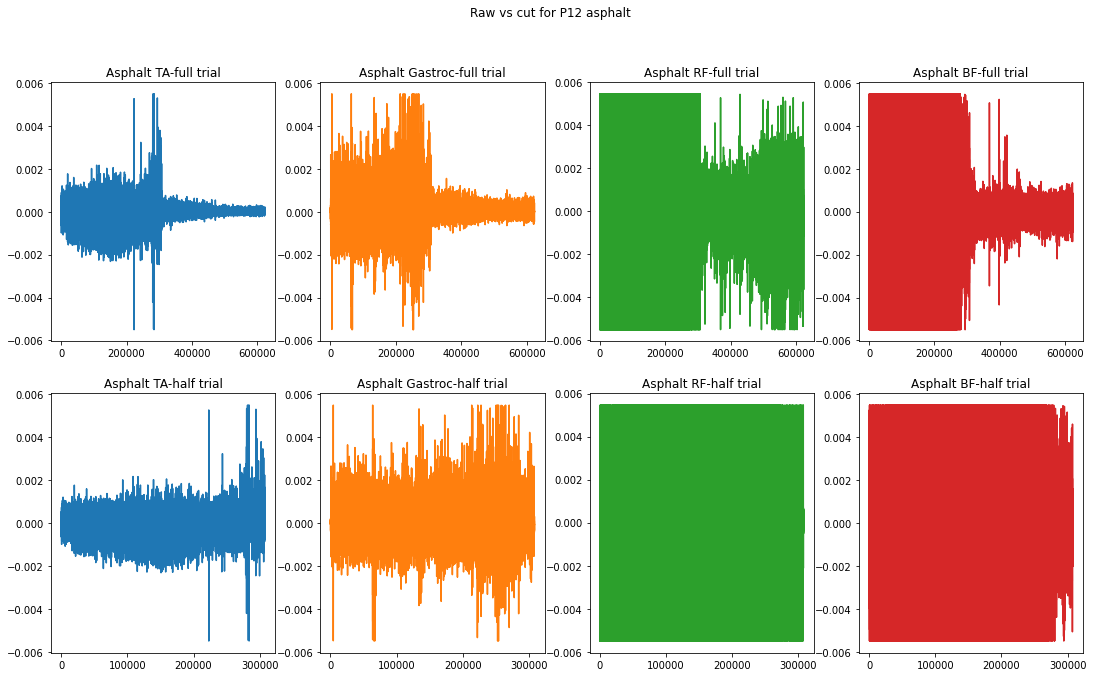

In [ ]:
import matplotlib.pyplot as plt
df_asphalt=df_asphalt_40

fig, ((ax1, ax2, ax3, ax4), (ax1_cut, ax2_cut, ax3_cut, ax4_cut)) = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Raw vs cut for P12 asphalt')

ax1.plot(list(range(0,len(df_asphalt.iloc[:,0]))),df_asphalt.iloc[:,1])
ax1.title.set_text('Asphalt TA-full trial') 
ax1.locator_params(axis='x', nbins=4) 
ax2.plot(list(range(0,len(df_asphalt.iloc[:,0]))),df_asphalt.iloc[:,2], 'tab:orange')
ax2.title.set_text('Asphalt Gastroc-full trial') 
ax2.locator_params(axis='x', nbins=4) 
ax3.plot(list(range(0,len(df_asphalt.iloc[:,0]))),df_asphalt.iloc[:,3], 'tab:green')
ax3.title.set_text('Asphalt RF-full trial') 
ax3.locator_params(axis='x', nbins=4) 
ax4.plot(list(range(0,len(df_asphalt.iloc[:,0]))),df_asphalt.iloc[:,4], 'tab:red')
ax4.title.set_text('Asphalt BF-full trial') 
ax4.locator_params(axis='x', nbins=4) 

ax1_cut.plot(list(range(0,len(df_asphalt.iloc[0:308160,0]))),df_asphalt.iloc[0:308160,1])
ax1_cut.title.set_text('Asphalt TA-half trial')
ax1_cut.locator_params(axis='x', nbins=4) 
ax2_cut.plot(list(range(0,len(df_asphalt.iloc[0:308160,0]))),df_asphalt.iloc[0:308160,2], 'tab:orange')
ax2_cut.title.set_text('Asphalt Gastroc-half trial')
ax2_cut.locator_params(axis='x', nbins=4) 
ax3_cut.plot(list(range(0,len(df_asphalt.iloc[0:308160,0]))),df_asphalt.iloc[0:308160,3], 'tab:green')
ax3_cut.title.set_text('Asphalt RF-half trial')
ax3_cut.locator_params(axis='x', nbins=4) 
ax4_cut.plot(list(range(0,len(df_asphalt.iloc[0:308160,0]))),df_asphalt.iloc[0:308160,4], 'tab:red')
ax4_cut.title.set_text('Asphalt BF-half trial') 
ax4_cut.locator_params(axis='x', nbins=4) 


Filtering EMG signals with banpass

In [ ]:
df_grass_2_filt=filteremg(emg=df_grass_2, Fs=1926, high_band=20, low_band=500)
df_asphalt_2_filt=filteremg(emg=df_asphalt_2, Fs=1926, high_band=20, low_band=500)

# df_grass_3_filt=filteremg(emg=df_grass_3, Fs=1926, high_band=20, low_band=500)
# df_asphalt_3_filt=filteremg(emg=df_asphalt_3, Fs=1926, high_band=20, low_band=500)

# df_grass_5_filt=filteremg(emg=df_grass_5, Fs=1926, high_band=20, low_band=500)
# df_asphalt_5_filt=filteremg(emg=df_asphalt_5, Fs=1926, high_band=20, low_band=500)

# df_grass_7_filt=filteremg(emg=df_grass_7, Fs=1926, high_band=20, low_band=500)
# df_asphalt_7_filt=filteremg(emg=df_asphalt_7, Fs=1926, high_band=20, low_band=500)

# df_grass_9_filt=filteremg(emg=df_grass_9, Fs=1926, high_band=20, low_band=500)
# df_asphalt_9_filt=filteremg(emg=df_asphalt_9, Fs=1926, high_band=20, low_band=500)

# df_grass_20_filt=filteremg(emg=df_grass_20, Fs=1926, high_band=20, low_band=500)
# df_asphalt_20_filt=filteremg(emg=df_asphalt_20, Fs=1926, high_band=20, low_band=500)

# df_grass_24_filt=filteremg(emg=df_grass_24, Fs=1926, high_band=20, low_band=500)
# df_asphalt_24_filt=filteremg(emg=df_asphalt_24, Fs=1926, high_band=20, low_band=500)

# df_grass_4_filt=filteremg(emg=df_grass_4, Fs=1926, high_band=20, low_band=500)
# df_asphalt_4_filt=filteremg(emg=df_asphalt_4, Fs=1926, high_band=20, low_band=500)

# df_grass_8_filt=filteremg(emg=df_grass_8, Fs=1926, high_band=20, low_band=500)
# df_asphalt_8_filt=filteremg(emg=df_asphalt_8, Fs=1926, high_band=20, low_band=500)

# df_grass_10_filt=filteremg(emg=df_grass_10, Fs=1926, high_band=20, low_band=500)
# df_asphalt_10_filt=filteremg(emg=df_asphalt_10, Fs=1926, high_band=20, low_band=500)

# df_grass_11_filt=filteremg(emg=df_grass_11, Fs=1926, high_band=20, low_band=500)
# df_asphalt_11_filt=filteremg(emg=df_asphalt_11, Fs=1926, high_band=20, low_band=500)

# df_grass_12_filt=filteremg(emg=df_grass_12, Fs=1926, high_band=20, low_band=500)
# df_asphalt_12_filt=filteremg(emg=df_asphalt_12, Fs=1926, high_band=20, low_band=500)

df_grass_13_filt=filteremg(emg=df_grass_13, Fs=1926, high_band=20, low_band=500)
df_asphalt_13_filt=filteremg(emg=df_asphalt_13, Fs=1926, high_band=20, low_band=500)

df_grass_14_filt=filteremg(emg=df_grass_14, Fs=1926, high_band=20, low_band=500)
df_asphalt_14_filt=filteremg(emg=df_asphalt_14, Fs=1926, high_band=20, low_band=500)

df_grass_15_filt=filteremg(emg=df_grass_15, Fs=1926, high_band=20, low_band=500)
df_asphalt_15_filt=filteremg(emg=df_asphalt_15, Fs=1926, high_band=20, low_band=500)

df_grass_16_filt=filteremg(emg=df_grass_16, Fs=1926, high_band=20, low_band=500)
df_asphalt_16_filt=filteremg(emg=df_asphalt_16, Fs=1926, high_band=20, low_band=500)

df_grass_17_filt=filteremg(emg=df_grass_17, Fs=1926, high_band=20, low_band=500)
df_asphalt_17_filt=filteremg(emg=df_asphalt_17, Fs=1926, high_band=20, low_band=500)

df_grass_18_filt=filteremg(emg=df_grass_18, Fs=1926, high_band=20, low_band=500)
df_asphalt_18_filt=filteremg(emg=df_asphalt_18, Fs=1926, high_band=20, low_band=500)

df_grass_19_filt=filteremg(emg=df_grass_19, Fs=1926, high_band=20, low_band=500)
df_asphalt_19_filt=filteremg(emg=df_asphalt_19, Fs=1926, high_band=20, low_band=500)

df_grass_21_filt=filteremg(emg=df_grass_21, Fs=1926, high_band=20, low_band=500)
df_asphalt_21_filt=filteremg(emg=df_asphalt_21, Fs=1926, high_band=20, low_band=500)

df_grass_22_filt=filteremg(emg=df_grass_22, Fs=1926, high_band=20, low_band=500)
df_asphalt_22_filt=filteremg(emg=df_asphalt_22, Fs=1926, high_band=20, low_band=500)

df_grass_23_filt=filteremg(emg=df_grass_23, Fs=1926, high_band=20, low_band=500)
df_asphalt_23_filt=filteremg(emg=df_asphalt_23, Fs=1926, high_band=20, low_band=500)

df_grass_25_filt=filteremg(emg=df_grass_25, Fs=1926, high_band=20, low_band=500)
df_asphalt_25_filt=filteremg(emg=df_asphalt_25, Fs=1926, high_band=20, low_band=500)

df_grass_26_filt=filteremg(emg=df_grass_26, Fs=1926, high_band=20, low_band=500)
df_asphalt_26_filt=filteremg(emg=df_asphalt_26, Fs=1926, high_band=20, low_band=500)

df_grass_27_filt=filteremg(emg=df_grass_27, Fs=1926, high_band=20, low_band=500)
df_asphalt_27_filt=filteremg(emg=df_asphalt_27, Fs=1926, high_band=20, low_band=500)

df_grass_28_filt=filteremg(emg=df_grass_28, Fs=1926, high_band=20, low_band=500)
df_asphalt_28_filt=filteremg(emg=df_asphalt_28, Fs=1926, high_band=20, low_band=500)

In [ ]:
df_grass_29_filt=filteremg(emg=df_grass_29, Fs=1926, high_band=20, low_band=500)
df_asphalt_29_filt=filteremg(emg=df_asphalt_29, Fs=1926, high_band=20, low_band=500)

df_grass_30_filt=filteremg(emg=df_grass_30, Fs=1926, high_band=20, low_band=500)
df_asphalt_30_filt=filteremg(emg=df_asphalt_30, Fs=1926, high_band=20, low_band=500)

df_grass_31_filt=filteremg(emg=df_grass_31, Fs=1926, high_band=20, low_band=500)
df_asphalt_31_filt=filteremg(emg=df_asphalt_31, Fs=1926, high_band=20, low_band=500)

df_grass_32_filt=filteremg(emg=df_grass_32, Fs=1926, high_band=20, low_band=500)
df_asphalt_32_filt=filteremg(emg=df_asphalt_32, Fs=1926, high_band=20, low_band=500)

df_grass_33_filt=filteremg(emg=df_grass_33, Fs=1926, high_band=20, low_band=500)
df_asphalt_33_filt=filteremg(emg=df_asphalt_33, Fs=1926, high_band=20, low_band=500)

df_grass_34_filt=filteremg(emg=df_grass_34, Fs=1926, high_band=20, low_band=500)
df_asphalt_34_filt=filteremg(emg=df_asphalt_34, Fs=1926, high_band=20, low_band=500)

df_grass_35_filt=filteremg(emg=df_grass_35, Fs=1926, high_band=20, low_band=500)
df_asphalt_35_filt=filteremg(emg=df_asphalt_35, Fs=1926, high_band=20, low_band=500)

df_grass_36_filt=filteremg(emg=df_grass_36, Fs=1926, high_band=20, low_band=500)
df_asphalt_36_filt=filteremg(emg=df_asphalt_36, Fs=1926, high_band=20, low_band=500)

df_grass_37_filt=filteremg(emg=df_grass_37, Fs=1926, high_band=20, low_band=500)
df_asphalt_37_filt=filteremg(emg=df_asphalt_37, Fs=1926, high_band=20, low_band=500)

df_grass_38_filt=filteremg(emg=df_grass_38, Fs=1926, high_band=20, low_band=500)
df_asphalt_38_filt=filteremg(emg=df_asphalt_38, Fs=1926, high_band=20, low_band=500)

df_grass_39_filt=filteremg(emg=df_grass_39, Fs=1926, high_band=20, low_band=500)
df_asphalt_39_filt=filteremg(emg=df_asphalt_39, Fs=1926, high_band=20, low_band=500)

df_grass_40_filt=filteremg(emg=df_grass_40, Fs=1926, high_band=20, low_band=500)
df_asphalt_40_filt=filteremg(emg=df_asphalt_40, Fs=1926, high_band=20, low_band=500)

df_grass_41_filt=filteremg(emg=df_grass_41, Fs=1926, high_band=20, low_band=500)
df_asphalt_41_filt=filteremg(emg=df_asphalt_41, Fs=1926, high_band=20, low_band=500)

In [ ]:
df_grass_39_filt=filteremg(emg=df_grass_39, Fs=1926, high_band=20, low_band=500)
df_asphalt_39_filt=filteremg(emg=df_asphalt_39, Fs=1926, high_band=20, low_band=500)

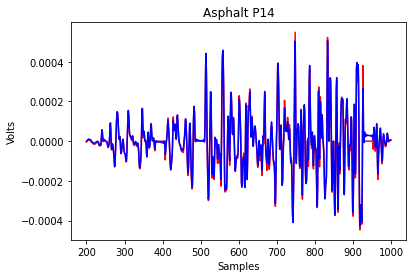

In [ ]:
#visualization of data filtered 
len_asphalt= list(range(200,1000))
plt.plot(len_asphalt,df_asphalt_14.iloc[200:1000,2],'r') 
plt.plot(len_asphalt,df_asphalt.iloc[200:1000,1],'b') 
plt.title('Asphalt P14') 
plt.xlabel('Samples')
plt.ylabel('Volts')
plt.show()


Normalize data to be betwen 0 and 1

In [ ]:
df_grass_2_norm=normalize(df_grass_2_filt)
df_asphalt_2_norm=normalize(df_asphalt_2_filt)
# df_grass_3_norm=normalize(df_grass_3_filt)
# df_asphalt_3_norm=normalize(df_asphalt_3_filt)
# df_grass_5_norm=normalize(df_grass_5_filt)
# df_asphalt_5_norm=normalize(df_asphalt_5_filt)
# df_grass_7_norm=normalize(df_grass_7_filt)
# df_asphalt_7_norm=normalize(df_asphalt_7_filt)
# df_grass_9_norm=normalize(df_grass_9_filt)
# df_asphalt_9_norm=normalize(df_asphalt_9_filt)
# df_grass_20_norm=normalize(df_grass_20_filt)
# df_asphalt_20_norm=normalize(df_asphalt_20_filt)
# df_grass_24_norm=normalize(df_grass_24_filt)
# df_asphalt_24_norm=normalize(df_asphalt_24_filt)
# df_grass_4_norm=normalize(df_grass_4_filt)
# df_asphalt_4_norm=normalize(df_asphalt_4_filt)
# df_grass_8_norm=normalize(df_grass_8_filt)
# df_asphalt_8_norm=normalize(df_asphalt_8_filt)
# df_grass_10_norm=normalize(df_grass_10_filt)
# df_asphalt_10_norm=normalize(df_asphalt_10_filt)
# df_grass_11_norm=normalize(df_grass_11_filt)
# df_asphalt_11_norm=normalize(df_asphalt_11_filt)
# df_grass_12_norm=normalize(df_grass_12_filt)
# df_asphalt_12_norm=normalize(df_asphalt_12_filt)
df_grass_13_norm=normalize(df_grass_13_filt)
df_asphalt_13_norm=normalize(df_asphalt_13_filt)
df_grass_14_norm=normalize(df_grass_14_filt)
df_asphalt_14_norm=normalize(df_asphalt_14_filt)
df_grass_15_norm=normalize(df_grass_15_filt)
df_asphalt_15_norm=normalize(df_asphalt_15_filt)
df_grass_16_norm=normalize(df_grass_16_filt)
df_asphalt_16_norm=normalize(df_asphalt_16_filt)
df_grass_17_norm=normalize(df_grass_17_filt)
df_asphalt_17_norm=normalize(df_asphalt_17_filt)
df_grass_18_norm=normalize(df_grass_18_filt)
df_asphalt_18_norm=normalize(df_asphalt_18_filt)
df_grass_19_norm=normalize(df_grass_19_filt)
df_asphalt_19_norm=normalize(df_asphalt_19_filt)
df_grass_21_norm=normalize(df_grass_21_filt)
df_asphalt_21_norm=normalize(df_asphalt_21_filt)
df_grass_22_norm=normalize(df_grass_22_filt)
df_asphalt_22_norm=normalize(df_asphalt_22_filt)
df_grass_23_norm=normalize(df_grass_23_filt)
df_asphalt_23_norm=normalize(df_asphalt_23_filt)
df_grass_25_norm=normalize(df_grass_25_filt)
df_asphalt_25_norm=normalize(df_asphalt_25_filt)
df_grass_26_norm=normalize(df_grass_26_filt)
df_asphalt_26_norm=normalize(df_asphalt_26_filt)
df_grass_27_norm=normalize(df_grass_27_filt)
df_asphalt_27_norm=normalize(df_asphalt_27_filt)
df_grass_28_norm=normalize(df_grass_28_filt)
df_asphalt_28_norm=normalize(df_asphalt_28_filt)

In [ ]:
df_grass_29_norm=normalize(df_grass_29_filt)
df_asphalt_29_norm=normalize(df_asphalt_29_filt)
df_grass_30_norm=normalize(df_grass_30_filt)
df_asphalt_30_norm=normalize(df_asphalt_30_filt)
df_grass_31_norm=normalize(df_grass_31_filt)
df_asphalt_31_norm=normalize(df_asphalt_31_filt)
df_grass_32_norm=normalize(df_grass_32_filt)
df_asphalt_32_norm=normalize(df_asphalt_32_filt)
df_grass_33_norm=normalize(df_grass_33_filt)
df_asphalt_33_norm=normalize(df_asphalt_33_filt)
df_grass_34_norm=normalize(df_grass_34_filt)
df_asphalt_34_norm=normalize(df_asphalt_34_filt)
df_grass_35_norm=normalize(df_grass_35_filt)
df_asphalt_35_norm=normalize(df_asphalt_35_filt)
df_grass_36_norm=normalize(df_grass_36_filt)
df_asphalt_36_norm=normalize(df_asphalt_36_filt)
df_grass_37_norm=normalize(df_grass_37_filt)
df_asphalt_37_norm=normalize(df_asphalt_37_filt)
df_grass_38_norm=normalize(df_grass_38_filt)
df_asphalt_38_norm=normalize(df_asphalt_38_filt)
df_grass_39_norm=normalize(df_grass_39_filt)
df_asphalt_39_norm=normalize(df_asphalt_39_filt)
df_grass_40_norm=normalize(df_grass_40_filt)
df_asphalt_40_norm=normalize(df_asphalt_40_filt)
df_grass_41_norm=normalize(df_grass_41_filt)
df_asphalt_41_norm=normalize(df_asphalt_41_filt)

In [ ]:
df_grass_39_norm=normalize(df_grass_39_filt)
df_asphalt_39_norm=normalize(df_asphalt_39_filt)

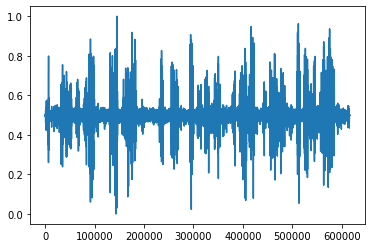

In [ ]:
plt.plot(df_asphalt_14_norm[2])
plt.title('Asphalt P14') 
plt.xlabel('Samples')
plt.ylabel('Volts')
plt.show()

Convert to data frame

In [ ]:
df_grass_2_norm=(pd.DataFrame(df_grass_2_norm)).T
df_asphalt_2_norm=(pd.DataFrame(df_asphalt_2_norm)).T
# df_grass_3_norm=(pd.DataFrame(df_grass_3_norm)).T
# df_asphalt_3_norm=(pd.DataFrame(df_asphalt_3_norm)).T
# df_grass_5_norm=(pd.DataFrame(df_grass_5_norm)).T
# df_asphalt_5_norm=(pd.DataFrame(df_asphalt_5_norm)).T
# df_grass_7_norm=(pd.DataFrame(df_grass_7_norm)).T
# df_asphalt_7_norm=(pd.DataFrame(df_asphalt_7_norm)).T
# df_grass_9_norm=(pd.DataFrame(df_grass_9_norm)).T
# df_asphalt_9_norm=(pd.DataFrame(df_asphalt_9_norm)).T
# df_grass_20_norm=(pd.DataFrame(df_grass_20_norm)).T
# df_asphalt_20_norm=(pd.DataFrame(df_asphalt_20_norm)).T
# df_grass_24_norm=(pd.DataFrame(df_grass_24_norm)).T
# df_asphalt_24_norm=(pd.DataFrame(df_asphalt_24_norm)).T
# df_grass_4_norm=(pd.DataFrame(df_grass_4_norm)).T
# df_asphalt_4_norm=(pd.DataFrame(df_asphalt_4_norm)).T
# df_grass_8_norm=(pd.DataFrame(df_grass_8_norm)).T
# df_asphalt_8_norm=(pd.DataFrame(df_asphalt_8_norm)).T
# df_grass_10_norm=(pd.DataFrame(df_grass_10_norm)).T
# df_asphalt_10_norm=(pd.DataFrame(df_asphalt_10_norm)).T
# df_grass_11_norm=(pd.DataFrame(df_grass_11_norm)).T
# df_asphalt_11_norm=(pd.DataFrame(df_asphalt_11_norm)).T
# df_grass_12_norm=(pd.DataFrame(df_grass_12_norm)).T
# df_asphalt_12_norm=(pd.DataFrame(df_asphalt_12_norm)).T

df_grass_13_norm=(pd.DataFrame(df_grass_13_norm)).T
df_asphalt_13_norm=(pd.DataFrame(df_asphalt_13_norm)).T
df_grass_14_norm=(pd.DataFrame(df_grass_14_norm)).T
df_asphalt_14_norm=(pd.DataFrame(df_asphalt_14_norm)).T
df_grass_15_norm=(pd.DataFrame(df_grass_15_norm)).T
df_asphalt_15_norm=(pd.DataFrame(df_asphalt_15_norm)).T
df_grass_16_norm=(pd.DataFrame(df_grass_16_norm)).T
df_asphalt_16_norm=(pd.DataFrame(df_asphalt_16_norm)).T
df_grass_17_norm=(pd.DataFrame(df_grass_17_norm)).T
df_asphalt_17_norm=(pd.DataFrame(df_asphalt_17_norm)).T
df_grass_18_norm=(pd.DataFrame(df_grass_18_norm)).T
df_asphalt_18_norm=(pd.DataFrame(df_asphalt_18_norm)).T
df_grass_19_norm=(pd.DataFrame(df_grass_19_norm)).T
df_asphalt_19_norm=(pd.DataFrame(df_asphalt_19_norm)).T
df_grass_21_norm=(pd.DataFrame(df_grass_21_norm)).T
df_asphalt_21_norm=(pd.DataFrame(df_asphalt_21_norm)).T
df_grass_22_norm=(pd.DataFrame(df_grass_22_norm)).T
df_asphalt_22_norm=(pd.DataFrame(df_asphalt_22_norm)).T
df_grass_23_norm=(pd.DataFrame(df_grass_23_norm)).T
df_asphalt_23_norm=(pd.DataFrame(df_asphalt_23_norm)).T
df_grass_25_norm=(pd.DataFrame(df_grass_25_norm)).T
df_asphalt_25_norm=(pd.DataFrame(df_asphalt_25_norm)).T
df_grass_26_norm=(pd.DataFrame(df_grass_26_norm)).T
df_asphalt_26_norm=(pd.DataFrame(df_asphalt_26_norm)).T
df_grass_27_norm=(pd.DataFrame(df_grass_27_norm)).T
df_asphalt_27_norm=(pd.DataFrame(df_asphalt_27_norm)).T
df_grass_28_norm=(pd.DataFrame(df_grass_28_norm)).T
df_asphalt_28_norm=(pd.DataFrame(df_asphalt_28_norm)).T

In [ ]:
df_grass_29_norm=(pd.DataFrame(df_grass_29_norm)).T
df_asphalt_29_norm=(pd.DataFrame(df_asphalt_29_norm)).T
df_grass_30_norm=(pd.DataFrame(df_grass_30_norm)).T
df_asphalt_30_norm=(pd.DataFrame(df_asphalt_30_norm)).T
df_grass_31_norm=(pd.DataFrame(df_grass_31_norm)).T
df_asphalt_31_norm=(pd.DataFrame(df_asphalt_31_norm)).T
df_grass_32_norm=(pd.DataFrame(df_grass_32_norm)).T
df_asphalt_32_norm=(pd.DataFrame(df_asphalt_32_norm)).T
df_grass_33_norm=(pd.DataFrame(df_grass_33_norm)).T
df_asphalt_33_norm=(pd.DataFrame(df_asphalt_33_norm)).T
df_grass_34_norm=(pd.DataFrame(df_grass_34_norm)).T
df_asphalt_34_norm=(pd.DataFrame(df_asphalt_34_norm)).T
df_grass_35_norm=(pd.DataFrame(df_grass_35_norm)).T
df_asphalt_35_norm=(pd.DataFrame(df_asphalt_35_norm)).T
df_grass_36_norm=(pd.DataFrame(df_grass_36_norm)).T
df_asphalt_36_norm=(pd.DataFrame(df_asphalt_36_norm)).T
df_grass_37_norm=(pd.DataFrame(df_grass_37_norm)).T
df_asphalt_37_norm=(pd.DataFrame(df_asphalt_37_norm)).T
df_grass_38_norm=(pd.DataFrame(df_grass_38_norm)).T
df_asphalt_38_norm=(pd.DataFrame(df_asphalt_38_norm)).T
df_grass_39_norm=(pd.DataFrame(df_grass_39_norm)).T
df_asphalt_39_norm=(pd.DataFrame(df_asphalt_39_norm)).T
df_grass_40_norm=(pd.DataFrame(df_grass_40_norm)).T
df_asphalt_40_norm=(pd.DataFrame(df_asphalt_40_norm)).T
df_grass_41_norm=(pd.DataFrame(df_grass_41_norm)).T
df_asphalt_41_norm=(pd.DataFrame(df_asphalt_41_norm)).T

In [ ]:
df_grass_39_norm=(pd.DataFrame(df_grass_39_norm)).T
df_asphalt_39_norm=(pd.DataFrame(df_asphalt_39_norm)).T

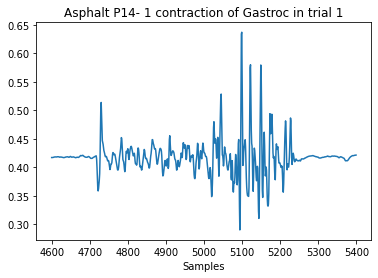

In [ ]:
plt.plot(df_asphalt_14_norm.iloc[4600:5400,1])
plt.title('Asphalt P14- 1 contraction of Gastroc in trial 1') 
plt.xlabel('Samples')
plt.show()

Save and open data with all pre-processed steps (pickle)

In [ ]:
df_grass_2_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_2_norm.pickle',df_grass_2_norm)
df_asphalt_2_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_2_norm.pickle',df_asphalt_2_norm)
# df_grass_3_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_3_norm.pickle',df_grass_3_norm)
# df_asphalt_3_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_3_norm.pickle',df_asphalt_3_norm)
# df_grass_4_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_4_norm.pickle',df_grass_4_norm)
# df_asphalt_4_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_4_norm.pickle',df_asphalt_4_norm)
# df_grass_5_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_5_norm.pickle',df_grass_5_norm)
# df_asphal_5_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_5_norm.pickle',df_asphalt_5_norm)
# df_grass_7_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_7_norm.pickle',df_grass_7_norm)
# df_asphalt_7_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_7_norm.pickle',df_asphalt_7_norm)
# df_grass_8_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_8_norm.pickle',df_grass_8_norm)
# df_asphalt_8_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_8_norm.pickle',df_asphalt_8_norm)
# df_grass_9_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_9_norm.pickle',df_grass_9_norm)
# df_asphalt_9_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_9_norm.pickle',df_asphalt_9_norm)
# df_grass_10_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_10_norm.pickle',df_grass_10_norm)
# df_asphalt_10_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_10_norm.pickle',df_asphalt_10_norm)
# df_grass_11_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_11_norm.pickle',df_grass_11_norm)
# df_asphalt_11_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_11_norm.pickle',df_asphalt_11_norm)
# df_grass_12_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_12_norm.pickle',df_grass_12_norm)
# df_asphalt_12_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_12_norm.pickle',df_asphalt_12_norm)
# df_grass_20_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_20_norm.pickle',df_grass_20_norm)
# df_asphalt_20_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_20_norm.pickle',df_asphalt_20_norm)
# df_grass_24_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_24_norm.pickle',df_grass_24_norm)
# df_asphalt_24_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_24_norm.pickle',df_asphalt_24_norm)

df_grass_13_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_13_norm.pickle',df_grass_13_norm)
df_asphalt_13_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_13_norm.pickle',df_asphalt_13_norm)
df_grass_14_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_14_norm.pickle',df_grass_14_norm)
df_asphalt_14_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_14_norm.pickle',df_asphalt_14_norm)
df_grass_15_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_15_norm.pickle',df_grass_15_norm)
df_asphalt_15_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_15_norm.pickle',df_asphalt_15_norm)
df_grass_16_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_16_norm.pickle',df_grass_16_norm)
df_asphalt_16_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_16_norm.pickle',df_asphalt_16_norm)
df_grass_17_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_17_norm.pickle',df_grass_17_norm)
df_asphalt_17_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_17_norm.pickle',df_asphalt_17_norm)
df_grass_18_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_18_norm.pickle',df_grass_18_norm)
df_asphalt_18_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_18_norm.pickle',df_asphalt_18_norm)
df_grass_19_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_19_norm.pickle',df_grass_19_norm)
df_asphalt_19_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_19_norm.pickle',df_asphalt_19_norm)
df_grass_21_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_21_norm.pickle',df_grass_21_norm)
df_asphalt_21_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_21_norm.pickle',df_asphalt_21_norm)
df_grass_22_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_22_norm.pickle',df_grass_22_norm)
df_asphalt_22_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_22_norm.pickle',df_asphalt_22_norm)
df_grass_23_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_23_norm.pickle',df_grass_23_norm)
df_asphalt_23_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_23_norm.pickle',df_asphalt_23_norm)
df_grass_25_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_25_norm.pickle',df_grass_25_norm)
df_asphalt_25_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_25_norm.pickle',df_asphalt_25_norm)
df_grass_26_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_26_norm.pickle',df_grass_26_norm)
df_asphalt_26_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_26_norm.pickle',df_asphalt_26_norm)
df_grass_27_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_27_norm.pickle',df_grass_27_norm)
df_asphalt_27_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_27_norm.pickle',df_asphalt_27_norm)
df_grass_28_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_28_norm.pickle',df_grass_28_norm)
df_asphalt_28_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_28_norm.pickle',df_asphalt_28_norm)

In [ ]:
df_grass_29_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_29_norm.pickle',df_grass_29_norm)
df_asphalt_29_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_29_norm.pickle',df_asphalt_29_norm)
df_grass_30_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_30_norm.pickle',df_grass_30_norm)
df_asphalt_30_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_30_norm.pickle',df_asphalt_30_norm)
df_grass_31_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_31_norm.pickle',df_grass_31_norm)
df_asphalt_31_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_31_norm.pickle',df_asphalt_31_norm)
df_grass_32_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_32_norm.pickle',df_grass_32_norm)
df_asphalt_32_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_32_norm.pickle',df_asphalt_32_norm)
df_grass_33_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_33_norm.pickle',df_grass_33_norm)
df_asphalt_33_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_33_norm.pickle',df_asphalt_33_norm)
df_grass_34_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_34_norm.pickle',df_grass_34_norm)
df_asphalt_34_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_34_norm.pickle',df_asphalt_34_norm)
df_grass_35_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_35_norm.pickle',df_grass_35_norm)
df_asphalt_35_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_35_norm.pickle',df_asphalt_35_norm)
df_grass_36_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_36_norm.pickle',df_grass_36_norm)
df_asphalt_36_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_36_norm.pickle',df_asphalt_36_norm)
df_grass_37_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_37_norm.pickle',df_grass_37_norm)
df_asphalt_37_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_37_norm.pickle',df_asphalt_37_norm)
df_grass_38_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_38_norm.pickle',df_grass_38_norm)
df_asphalt_38_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_38_norm.pickle',df_asphalt_38_norm)
df_grass_39_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_39_norm.pickle',df_grass_39_norm)
df_asphalt_39_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_39_norm.pickle',df_asphalt_39_norm)
df_grass_40_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_40_norm.pickle',df_grass_40_norm)
df_asphalt_40_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_40_norm.pickle',df_asphalt_40_norm)
df_grass_41_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_41_norm.pickle',df_grass_41_norm)
df_asphalt_41_norm=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_41_norm.pickle',df_asphalt_41_norm)

Sweat issue-CUT

In [ ]:
df_grass_2_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_3_norm.pickle')
df_asphalt_2_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_3_norm.pickle')
df_grass_2_cut, df_asphalt_2_cut=cut_sweat_no_interv(range(0,len(df_asphalt_2_norm)),range(0,0),range(0,len(df_asphalt_2_norm)),range(0,len(df_asphalt_2_norm)),range(0,len(df_asphalt_2_norm)),range(0,0),range(0,len(df_asphalt_2_norm)),range(0,len(df_asphalt_2_norm)),df_grass_2_norm,df_asphalt_2_norm)
T2_cut=create_tensor(df_asphalt_2_cut,df_grass_2_cut)
T2_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T2_cut.pickle',T2_cut)


In [ ]:
df_grass_3_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_3_norm.pickle')
df_asphalt_3_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_3_norm.pickle')
df_grass_3_cut, df_asphalt_3_cut=cut_sweat_no_interv(range(0,308160),range(0,308160),range(0,308160),range(0,308160),range(0,46224),range(0,len(df_asphalt_3_norm)),range(0,len(df_asphalt_3_norm)),range(0,len(df_asphalt_3_norm)),df_grass_3_norm,df_asphalt_3_norm)
T3_cut=create_tensor(df_asphalt_3_cut,df_grass_3_cut)
T3_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T3_cut.pickle',T3_cut)


In [ ]:
df_grass_5_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_5_norm.pickle')
df_asphalt_5_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_5_norm.pickle')
df_grass_5_cut, df_asphalt_5_cut=cut_sweat_no_interv(range(0,308160),range(423720,len(df_asphalt_5_norm)),range(0,len(df_asphalt_5_norm)),range(0,len(df_asphalt_5_norm)),range(0,308160),range(0,423720),range(0,len(df_asphalt_5_norm)),range(0,len(df_asphalt_5_norm)),df_grass_3_norm,df_asphalt_3_norm)
T5_cut=create_tensor(df_asphalt_5_cut,df_grass_5_cut)
T5_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T5_cut.pickle',T5_cut)


In [ ]:
df_grass_8_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_8_norm.pickle')
df_asphalt_8_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_8_norm.pickle')
df_grass_8_cut, df_asphalt_8_cut=cut_sweat_no_interv(range(0,308160),range(0,308160),range(0,len(df_asphalt_8_norm)),range(0,184896),range(0,len(df_asphalt_8_norm)),range(0,0),range(0,len(df_asphalt_8_norm)),range(0,0),df_grass_8_norm,df_asphalt_8_norm)                                           
T8_cut=create_tensor(df_asphalt_8_cut,df_grass_8_cut)
T8_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T8_cut.pickle',T8_cut)

In [ ]:
df_grass_9_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_9_norm.pickle')
df_asphalt_9_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_9_norm.pickle')
df_grass_9_cut, df_asphalt_9_cut=cut_sweat_no_interv(range(308160,len(df_asphalt_9_norm)),range(423720,len(df_asphalt_9_norm)),range(0,len(df_asphalt_9_norm)),range(0,len(df_asphalt_9_norm)),range(0,423720),range(0,446832),range(0,len(df_asphalt_9_norm)),range(0,len(df_asphalt_9_norm)),df_grass_9_norm,df_asphalt_9_norm)
T9_cut=create_tensor(df_asphalt_9_cut,df_grass_9_cut)
T9_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T9_cut.pickle',T9_cut)

In [ ]:
df_grass_10_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_10_norm.pickle')
df_asphalt_10_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_10_norm.pickle')
df_grass_10_cut, df_asphalt_10_cut=cut_sweat_no_interv(range(0,308160),range(0,len(df_asphalt_10_norm)),range(0,585504),range(0,len(df_asphalt_10_norm)),range(0,308160),range(0,len(df_asphalt_5_norm)),range(0,308160),range(0,308160),df_grass_10_norm,df_asphalt_10_norm)
T10_cut=create_tensor(df_asphalt_10_cut,df_grass_10_cut)
T10_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T10_cut.pickle',T10_cut)

In [ ]:
df_grass_11_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_11_norm.pickle')
df_asphalt_11_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_11_norm.pickle')
df_grass_11_cut, df_asphalt_11_cut=cut_sweat_no_interv(range(0,len(df_asphalt_11_norm)),range(0,len(df_asphalt_11_norm)),range(0,0),range(0,192600),range(0,len(df_asphalt_11_norm)),range(0,len(df_asphalt_11_norm)),range(0,len(df_asphalt_11_norm)),range(0,len(df_asphalt_11_norm)),df_grass_11_norm,df_asphalt_11_norm)
T11_cut=create_tensor(df_asphalt_11_cut,df_grass_11_cut)
T11_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T11_cut.pickle',T11_cut)

In [ ]:
df_grass_12_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_12_norm.pickle')
df_asphalt_12_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_12_norm.pickle')
df_grass_12_cut, df_asphalt_12_cut=cut_sweat_no_interv(range(0,308160),range(0,308160),range(0,len(df_asphalt_12_norm)),range(0,308160),range(0,308160),range(0,308160),range(0,308160),range(0,308160),df_grass_12_norm,df_asphalt_12_norm)
T12_cut=create_tensor(df_asphalt_12_cut,df_grass_12_cut)
T12_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T12_cut.pickle',T12_cut)

In [ ]:
df_grass_20_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_20_norm.pickle')
df_asphalt_20_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_20_norm.pickle')
df_grass_20_cut, df_asphalt_20_cut=cut_sweat_no_interv(range(0,len(df_grass_20_norm)),range(0,len(df_grass_20_norm)),range(0,len(df_grass_20_norm)),range(0,len(df_grass_20_norm)),range(0,len(df_asphalt_20_norm)),range(0,len(df_asphalt_20_norm)),range(0,len(df_asphalt_20_norm)),range(308160,len(df_asphalt_20_norm)),df_grass_20_norm,df_asphalt_20_norm)
T20_cut=create_tensor(df_asphalt_20_cut,df_grass_20_cut)
T20_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T20_cut.pickle',T20_cut)

In [ ]:
df_grass_13_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_13_norm.pickle')
df_asphalt_13_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_13_norm.pickle')
df_grass_13_cut, df_asphalt_13_cut=cut_sweat_no_interv(range(0,len(df_asphalt_13_norm)),range(0,len(df_asphalt_13_norm)),range(0,len(df_asphalt_13_norm)),range(0,0),range(0,len(df_asphalt_13_norm)),range(0,len(df_asphalt_13_norm)),range(0,len(df_asphalt_13_norm)),range(0,0),df_grass_13_norm,df_asphalt_13_norm)
T13_cut=create_tensor(df_asphalt_13_cut,df_grass_13_cut)
T13_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T13_cut.pickle',T13_cut)

In [ ]:
df_grass_14_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_14_norm.pickle')
df_asphalt_14_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_14_norm.pickle')
df_grass_14_cut, df_asphalt_14_cut=cut_sweat_no_interv(range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),range(0,len(df_asphalt_14_norm)),df_grass_14_norm,df_asphalt_14_norm)
T14_cut=create_tensor(df_asphalt_14_cut,df_grass_14_cut)
T14_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T14_cut.pickle',T14_cut)

In [ ]:
df_grass_15_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_15_norm.pickle')
df_asphalt_15_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_15_norm.pickle')
df_grass_15_cut, df_asphalt_15_cut=cut_sweat_no_interv(range(0,0),range(0,0),range(0,len(df_asphalt_15_norm)),range(0,len(df_asphalt_15_norm)),range(0,0),range(0,0),range(0,0),range(0,len(df_asphalt_15_norm)),df_grass_15_norm,df_asphalt_15_norm)
T15_cut=create_tensor(df_asphalt_15_cut,df_grass_15_cut)
T15_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T15_cut.pickle',T15_cut)

In [ ]:
df_grass_16_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_16_norm.pickle')
df_asphalt_16_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_16_norm.pickle')
df_grass_16_cut, df_asphalt_16_cut=cut_sweat_no_interv(range(0,0),range(0,0),range(0,0),range(0,0),range(0,0),range(0,0),range(0,0),range(0,len(df_asphalt_16_norm)),df_grass_16_norm,df_asphalt_16_norm) ##not good
T16_cut=create_tensor(df_asphalt_16_cut,df_grass_16_cut)
T16_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T16_cut.pickle',T16_cut)

In [ ]:
df_grass_17_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_17_norm.pickle')
df_asphalt_17_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_17_norm.pickle')
df_grass_17_cut, df_asphalt_17_cut=cut_sweat_no_interv(range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),range(0,len(df_asphalt_17_norm)),df_grass_17_norm,df_asphalt_17_norm)
T17_cut=create_tensor(df_asphalt_17_cut,df_grass_17_cut)
T17_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T17_cut.pickle',T17_cut)

In [ ]:
df_grass_18_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_18_norm.pickle')
df_asphalt_18_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_18_norm.pickle')
df_grass_18_cut, df_asphalt_18_cut=cut_sweat_no_interv(range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),range(0,len(df_asphalt_18_norm)),df_grass_18_norm,df_asphalt_18_norm)
T18_cut=create_tensor(df_asphalt_18_cut,df_grass_18_cut)
T18_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T18_cut.pickle',T18_cut)

In [ ]:
df_grass_19_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_19_norm.pickle')
df_asphalt_19_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_19_norm.pickle')
df_grass_19_cut, df_asphalt_19_cut=cut_sweat_no_interv(range(0,len(df_asphalt_19_norm)),range(0,0),range(0,0),range(0,0),range(0,len(df_asphalt_19_norm)),range(0,0),range(0,0),range(0,0),df_grass_19_norm,df_asphalt_19_norm)
T19_cut=create_tensor(df_asphalt_19_cut,df_grass_19_cut)
T19_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T19_cut.pickle',T19_cut)

In [ ]:
df_grass_21_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_21_norm.pickle')
df_asphalt_21_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_21_norm.pickle')
df_grass_21_cut, df_asphalt_21_cut=cut_sweat_no_interv(range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),range(0,len(df_asphalt_21_norm)),df_grass_21_norm,df_asphalt_21_norm)
T21_cut=create_tensor(df_asphalt_21_cut,df_grass_21_cut)
T21_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T21_cut.pickle',T21_cut)

In [ ]:
df_grass_22_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_22_norm.pickle')
df_asphalt_22_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_22_norm.pickle')
df_grass_22_cut, df_asphalt_22_cut=cut_sweat_no_interv(range(0,0),range(0,0),range(0,0),range(100152,184896),range(0,0),range(0,0),range(0,0),range(200304,408312),df_grass_22_norm,df_asphalt_22_norm) ##not good
T22_cut=create_tensor(df_asphalt_22_cut,df_grass_22_cut)
T22_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T22_cut.pickle',T22_cut)

In [ ]:
df_grass_23_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_23_norm.pickle')
df_asphalt_23_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_23_norm.pickle')
df_grass_23_cut, df_asphalt_23_cut=cut_sweat_no_interv(range(0,len(df_asphalt_23_norm)),range(0,len(df_asphalt_23_norm)),range(0,len(df_asphalt_23_norm)),range(0,0),range(0,len(df_asphalt_23_norm)),range(0,len(df_asphalt_23_norm)),range(0,len(df_asphalt_23_norm)),range(0,0),df_grass_23_norm,df_asphalt_23_norm)
T23_cut=create_tensor(df_asphalt_23_cut,df_grass_23_cut)
T23_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T23_cut.pickle',T23_cut)

In [ ]:
df_grass_25_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_25_norm.pickle')
df_asphalt_25_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_25_norm.pickle')
df_grass_25_cut, df_asphalt_25_cut=cut_sweat_no_interv(range(0,0),range(0,len(df_asphalt_25_norm)),range(0,0),range(0,len(df_asphalt_25_norm)),range(0,0),range(0,len(df_asphalt_25_norm)),range(0,0),range(0,0),df_grass_25_norm,df_asphalt_25_norm)
T25_cut=create_tensor(df_asphalt_25_cut,df_grass_25_cut)
T25_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T25_cut.pickle',T25_cut)

In [ ]:
df_grass_26_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_26_norm.pickle')
df_asphalt_26_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_26_norm.pickle')
df_grass_26_cut, df_asphalt_26_cut=cut_sweat_no_interv(range(0,len(df_asphalt_26_norm)),range(0,len(df_asphalt_26_norm)),range(0,len(df_asphalt_26_norm)),range(0,0),range(46224,154080),range(46224,154080),range(0,154080),range(0,0),df_grass_26_norm,df_asphalt_26_norm)
T26_cut=create_tensor(df_asphalt_26_cut,df_grass_26_cut)
T26_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T26_cut.pickle',T26_cut)

In [ ]:
T3_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T3_cut.pickle')
T5_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T5_cut.pickle')
T8_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T8_cut.pickle')
T10_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T10_cut.pickle')
T11_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T11_cut.pickle')
T12_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T12_cut.pickle')
T13_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T13_cut.pickle')
T14_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T14_cut.pickle')
T17_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T17_cut.pickle')
T18_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T18_cut.pickle')
T19_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T19_cut.pickle')
T20_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T20_cut.pickle')
T21_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T21_cut.pickle')
T22_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T22_cut.pickle')
T23_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T23_cut.pickle')
T25_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T25_cut.pickle')
T26_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T26_cut.pickle')
T15_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T15_cut.pickle')
T16_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T16_cut.pickle')

In [ ]:
T_cut = tf.concat([T3_cut,T5_cut,T8_cut,T10_cut,T11_cut,T12_cut,T20_cut,T13_cut,T14_cut,T17_cut,T18_cut,T19_cut,T21_cut,T22_cut,T23_cut,T25_cut,T26_cut,T15_cut,T16_cut], axis=1)
print("Tensor_all shape:", T_cut.shape)
T_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T_cut.pickle',T_cut)


Tensor_all shape: (7704, 3023, 6)


In [ ]:
df_grass_27_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_27_norm.pickle')
df_asphalt_27_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_27_norm.pickle')
df_grass_27_cut, df_asphalt_27_cut=cut_sweat_no_interv(range(0,len(df_grass_27_norm)),range(0,len(df_grass_27_norm)),range(0,len(df_grass_27_norm)),range(0,len(df_grass_27_norm)),range(169488,223416),range(154080,454536),range(0,0),range(0,len(df_asphalt_27_norm)),df_grass_27_norm,df_asphalt_27_norm)
T27_cut=create_tensor(df_asphalt_27_cut,df_grass_27_cut)
T27_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T27_cut.pickle',T27_cut)

In [ ]:
# #participant with mutiple interval
# #Participant 4
df_grass_4_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_4_norm.pickle')
df_asphalt_4_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_4_norm.pickle')
df_grass_4_cut_TA=df_grass_4_norm.iloc[range(0,208008),0].append(df_grass_4_norm.iloc[range(285048,len(df_grass_4_norm)), 0]) 
df_grass_4_cut_Gas=np.zeros(len(df_grass_4_cut_TA))
df_grass_4_cut_RF=df_grass_4_norm.iloc[range(0,146376),2].append(df_grass_4_norm.iloc[range(200304,len(df_grass_4_norm)), 2])
df_grass_4_cut_BF=df_grass_4_norm.iloc[200304:,3]
df_grass_4_cut=pd.DataFrame([df_grass_4_cut_TA,df_grass_4_cut_Gas,df_grass_4_cut_RF,df_grass_4_cut_BF,df_grass_4_norm[4],df_grass_4_norm[5]])
df_grass_4_cut=(df_grass_4_cut.fillna(0)).T
df_asphalt_4_cut_TA=df_asphalt_4_norm.iloc[:308160,0]
df_asphalt_4_cut_Gas=df_asphalt_4_norm.iloc[:223416,0]
df_asphalt_4_cut_RF=df_asphalt_4_norm.iloc[:208008,0]
df_asphalt_4_cut_BF=df_asphalt_4_norm.iloc[354384:,0]
df_asphalt_4_cut=pd.DataFrame([df_asphalt_4_cut_TA,df_asphalt_4_cut_Gas, df_asphalt_4_cut_RF,df_asphalt_4_cut_BF,df_asphalt_4_norm[4],df_asphalt_4_norm[5]])
df_asphalt_4_cut=(df_asphalt_4_cut.fillna(0)).T

T4_cut=create_tensor(df_asphalt_4_cut,df_grass_4_cut)
T4_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T4_cut.pickle',T4_cut)

#Participant 7
df_grass_7_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_7_norm.pickle')
df_asphalt_7_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_7_norm.pickle')
df_grass_7_cut_TA=df_grass_7_norm.iloc[:308160,0]
df_grass_7_cut_Gas=df_grass_7_norm.iloc[range(308160,392904),1].append(df_grass_7_norm.iloc[range(454536,556984), 1])
df_grass_7_cut_RF=df_grass_7_norm.iloc[:308160,2]
df_grass_7_cut_BF=df_grass_7_norm.iloc[:,3]
df_grass_7_cut=pd.DataFrame([df_grass_7_cut_TA,df_grass_7_cut_Gas,df_grass_7_cut_RF,df_grass_7_cut_BF,df_grass_7_norm[4],df_grass_7_norm[5]])
df_grass_7_cut=(df_grass_7_cut.fillna(0)).T
df_asphalt_7_cut_TA=df_asphalt_7_norm.iloc[184896:223416,0]
df_asphalt_7_cut_Gas=df_asphalt_7_norm.iloc[:408312,1]
df_asphalt_7_cut_RF=df_asphalt_7_norm.iloc[:308160,2]
df_asphalt_7_cut_BF=df_asphalt_7_norm.iloc[:308160,3]
df_asphalt_7_cut=pd.DataFrame([df_asphalt_7_cut_TA,df_asphalt_7_cut_Gas, df_asphalt_7_cut_RF,df_asphalt_7_cut_BF,df_asphalt_7_norm[4],df_asphalt_7_norm[5]])
df_asphalt_7_cut=(df_asphalt_7_cut.fillna(0)).T

T7_cut=create_tensor(df_asphalt_7_cut,df_grass_7_cut)
T7_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T7_cut.pickle',T7_cut)

#Participant 24
df_grass_24_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_24_norm.pickle')
df_asphalt_24_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_24_norm.pickle')
df_grass_24_cut_TA=np.zeros(len(df_grass_24_norm))
df_grass_24_cut_Gas=np.zeros(len(df_grass_24_norm))
df_grass_24_cut_RF=df_grass_24_norm.iloc[range(0,177192),2].append(df_grass_24_norm.iloc[range(231120,246528), 2])
df_grass_24_cut_BF=df_grass_24_norm.iloc[:308160,3]
df_grass_24_cut=pd.DataFrame([df_grass_24_cut_TA,df_grass_24_cut_Gas,df_grass_24_cut_RF,df_grass_24_cut_BF,df_grass_24_norm[4],df_grass_24_norm[5]])
df_grass_24_cut=(df_grass_24_cut.fillna(0)).T
df_asphalt_24_cut_TA=df_asphalt_24_norm.iloc[184896:223416,0]
df_asphalt_24_cut_Gas=df_asphalt_24_norm.iloc[:408312,1]
df_asphalt_24_cut_RF=df_asphalt_24_norm.iloc[range(0,177192),2].append(df_asphalt_24_norm.iloc[range(431424,577800), 2])
df_asphalt_24_cut_BF=df_asphalt_24_norm.iloc[:,3]
df_asphalt_24_cut=pd.DataFrame([df_asphalt_24_cut_TA,df_asphalt_24_cut_Gas, df_asphalt_24_cut_RF,df_asphalt_24_cut_BF,df_asphalt_24_norm[4],df_asphalt_24_norm[5]])
df_asphalt_24_cut=(df_asphalt_24_cut.fillna(0)).T

T24_cut=create_tensor(df_asphalt_24_cut,df_grass_24_cut)
T24_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T24_cut.pickle',T24_cut)

#Participant 28
df_grass_28_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_28_norm.pickle')
df_asphalt_28_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_28_norm.pickle')
df_grass_28_cut_TA=df_grass_28_norm.iloc[:,0]
df_grass_28_cut_Gas=np.zeros(len(df_grass_28_norm))
df_grass_28_cut_RF=np.zeros(len(df_grass_28_norm))
df_grass_28_cut_BF=np.zeros(len(df_grass_28_norm))
df_grass_28_cut=pd.DataFrame([df_grass_28_cut_TA,df_grass_28_cut_Gas,df_grass_28_cut_RF,df_grass_28_cut_BF,df_grass_28_norm[4],df_grass_28_norm[5]])
df_grass_28_cut=(df_grass_28_cut.fillna(0)).T
df_asphalt_28_cut_TA=df_asphalt_28_norm.iloc[:,0]
df_asphalt_28_cut_Gas=((((df_asphalt_28_norm.iloc[range(0,23112),1].append(df_asphalt_28_norm.iloc[range(77040,100152), 1])).append(df_asphalt_28_norm.iloc[range(215712,231120), 1])).append(df_asphalt_28_norm.iloc[range(261936,285048), 1])).append(df_asphalt_28_norm.iloc[range(346680,377496), 1])).append(df_asphalt_28_norm.iloc[range(469944,593208), 1])
df_asphalt_28_cut_RF=np.zeros(len(df_asphalt_28_norm))
df_asphalt_28_cut_BF=np.zeros(len(df_asphalt_28_norm))
df_asphalt_28_cut=pd.DataFrame([df_asphalt_28_cut_TA,df_asphalt_28_cut_Gas, df_asphalt_28_cut_RF,df_asphalt_28_cut_BF,df_asphalt_28_norm[4],df_asphalt_28_norm[5]])
df_asphalt_28_cut=(df_asphalt_28_cut.fillna(0)).T

T28_cut=create_tensor(df_asphalt_28_cut,df_grass_28_cut)
T28_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T28_cut.pickle',T28_cut)


In [ ]:

T4_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T4_cut.pickle')
T7_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T7_cut.pickle')
T24_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T24_cut.pickle')
T27_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T27_cut.pickle')
T28_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T28_cut.pickle')
T2_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T2_cut.pickle')


In [ ]:
T_cut2 = tf.concat([T4_cut,T7_cut,T24_cut,T2_cut,T27_cut,T28_cut], axis=1)
print("Tensor_all shape:", T_cut2.shape)
T_cut2=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T_cut2.pickle',T_cut2)

Tensor_all shape: (7704, 937, 6)


In [ ]:
#P29
df_grass_29_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_29_norm.pickle')
df_asphalt_29_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_29_norm.pickle')
df_grass_29_cut, df_asphalt_29_cut=cut_sweat_no_interv(range(300456,423720),range(0,308160),range(200304,len(df_grass_29_norm)),range(0,len(df_grass_29_norm)),range(385200,446832),range(0,408312),range(308160, len(df_asphalt_29_norm)),range(308160, len(df_asphalt_29_norm)),df_grass_29_norm,df_asphalt_29_norm)
T29_cut=create_tensor(df_asphalt_29_cut,df_grass_29_cut)
T29_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T29_cut.pickle',T29_cut)

In [ ]:
#P32
df_grass_32_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_32_norm.pickle')
df_asphalt_32_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_32_norm.pickle')
df_grass_32_cut, df_asphalt_32_cut=cut_sweat_no_interv(range(0,len(df_grass_32_norm)),range(0,308160),range(0,308160),range(0,len(df_grass_32_norm)),range(0,len(df_asphalt_32_norm)),range(0,200304),range(0,len(df_asphalt_32_norm)),range(0,len(df_asphalt_32_norm)),df_grass_32_norm,df_asphalt_32_norm)
T32_cut=create_tensor(df_asphalt_32_cut,df_grass_32_cut)
T32_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T32_cut.pickle',T32_cut)

In [ ]:
#P41
df_grass_41_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_41_norm.pickle')
df_asphalt_41_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_41_norm.pickle')
df_grass_41_cut, df_asphalt_41_cut=cut_sweat_no_interv(range(0,208008),range(0,146376),range(0,len(df_grass_41_norm)),range(0,308160),range(0,0),range(0,308160),range(0,0),range(3200304,300456),df_grass_41_norm,df_asphalt_41_norm)
T41_cut=create_tensor(df_asphalt_41_cut,df_grass_41_cut)
T41_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T41_cut.pickle',T41_cut)


In [ ]:
#P29
df_grass_29_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_29_norm.pickle')
df_asphalt_29_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_29_norm.pickle')
df_grass_29_cut, df_asphalt_29_cut=cut_sweat_no_interv(range(300456,423720),range(0,308160),range(200304,len(df_grass_29_norm)),range(0,len(df_grass_29_norm)),range(385200,446832),range(0,408312),range(308160, len(df_asphalt_29_norm)),range(308160, len(df_asphalt_29_norm)),df_grass_29_norm,df_asphalt_29_norm)
T29_cut=create_tensor(df_asphalt_29_cut,df_grass_29_cut)
T29_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T29_cut.pickle',T29_cut)

#P30
df_grass_30_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_30_norm.pickle')
df_asphalt_30_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_30_norm.pickle')
df_grass_30_cut, df_asphalt_30_cut=cut_sweat_no_interv(range(0,0),range(0,0),range(0,308160),range(0,308160),range(0,0),range(0,0),range(0,308160),range(0,146376),df_grass_30_norm,df_asphalt_30_norm)
T30_cut=create_tensor(df_asphalt_30_cut,df_grass_30_cut)
T30_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T30_cut.pickle',T30_cut)

#P31
df_grass_31_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_31_norm.pickle')
df_asphalt_31_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_31_norm.pickle')
df_grass_31_cut, df_asphalt_31_cut=cut_sweat_no_interv(range(0,477648),range(308160,len(df_grass_31_norm)),range(0,346680),range(0,446832),range(0,len(df_asphalt_31_norm)),range(85200, len(df_grass_31_norm)),range(0,len(df_grass_31_norm)),range(0,308160),df_grass_31_norm,df_asphalt_31_norm)
T31_cut=create_tensor(df_asphalt_31_cut,df_grass_31_cut)
T31_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T31_cut.pickle',T31_cut)

#P32
df_grass_32_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_32_norm.pickle')
df_asphalt_32_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_32_norm.pickle')
df_grass_32_cut, df_asphalt_32_cut=cut_sweat_no_interv(range(0,len(df_grass_32_norm)),range(0,308160),range(0,308160),range(0,len(df_grass_32_norm)),range(0,len(df_asphalt_32_norm)),range(0,200304),range(0,len(df_asphalt_32_norm)),range(0,len(df_asphalt_32_norm)),df_grass_32_norm,df_asphalt_32_norm)
T32_cut=create_tensor(df_asphalt_32_cut,df_grass_32_cut)
T32_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T32_cut.pickle',T32_cut)

#P33
df_grass_33_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_33_norm.pickle')
df_asphalt_33_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_33_norm.pickle')
df_grass_33_cut, df_asphalt_33_cut=cut_sweat_no_interv(range(0,308160),range(0,len(df_grass_33_norm)),range(0,308160),range(0,len(df_grass_33_norm)),range(184896,300456),range(0,len(df_asphalt_33_norm)),range(200304,493056),range(0,200304),df_grass_33_norm,df_asphalt_33_norm)
T33_cut=create_tensor(df_asphalt_33_cut,df_grass_33_cut)
T33_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T33_cut.pickle',T33_cut)

#P34
df_grass_34_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_34_norm.pickle')
df_asphalt_34_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_34_norm.pickle')
df_grass_34_cut, df_asphalt_34_cut=cut_sweat_no_interv(range(0,0),range(0,308160),range(0,0),range(200304,len(df_grass_34_norm)),range(0,0),range(0,0),range(0,0),range(0, len(df_asphalt_34_norm)),df_grass_34_norm,df_asphalt_34_norm)
T34_cut=create_tensor(df_asphalt_34_cut,df_grass_34_cut)
T34_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T34_cut.pickle',T34_cut)

#P35
df_grass_35_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_35_norm.pickle')
df_asphalt_35_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_35_norm.pickle')
df_grass_35_cut, df_asphalt_35_cut=cut_sweat_no_interv(range(446832, len(df_grass_35_norm)),range(0,308160),range(0,446832),range(446832,len(df_grass_35_norm)),range(0,200304),range(0,400608),range(446832,546984),range(500760, len(df_asphalt_35_norm)),df_grass_35_norm,df_asphalt_35_norm)
T35_cut=create_tensor(df_asphalt_35_cut,df_grass_35_cut)
T35_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T35_cut.pickle',T35_cut)

#P36
df_grass_36_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_36_norm.pickle')
df_asphalt_36_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_36_norm.pickle')
df_grass_36_cut, df_asphalt_36_cut=cut_sweat_no_interv(range(0,308160),range(0,546984),range(0,len(df_grass_36_norm)),range(0,308160),range(0,0),range(0,len(df_asphalt_36_norm)),range(0,len(df_asphalt_36_norm)),range(0,0),df_grass_36_norm,df_asphalt_36_norm)
T36_cut=create_tensor(df_asphalt_36_cut,df_grass_36_cut)
T36_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T36_cut.pickle',T36_cut)
#P37
df_grass_37_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_37_norm.pickle')
df_asphalt_37_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_37_norm.pickle')
df_grass_37_cut, df_asphalt_37_cut=cut_sweat_no_interv(range(0,308160),range(0,308160),range(0,0),range(308160,len(df_grass_37_norm)),range(0,len(df_asphalt_37_norm)),range(0,len(df_asphalt_37_norm)),range(0,308160),range(0,308160),df_grass_37_norm,df_asphalt_37_norm)
T37_cut=create_tensor(df_asphalt_37_cut,df_grass_37_cut)
T37_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T37_cut.pickle',T37_cut)

#P38
df_grass_38_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_38_norm.pickle')
df_asphalt_38_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_38_norm.pickle')
df_grass_38_cut, df_asphalt_38_cut=cut_sweat_no_interv(range(0,308160),range(0,0),range(0,308160),range(0,308160),range(0,len(df_asphalt_38_norm)),range(0,len(df_asphalt_38_norm)),range(0,308160),range(0,len(df_asphalt_38_norm)),df_grass_38_norm,df_asphalt_38_norm)
T38_cut=create_tensor(df_asphalt_38_cut,df_grass_38_cut)
T38_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T38_cut.pickle',T38_cut)

#P39
df_grass_39_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_39_norm.pickle')
df_asphalt_39_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_39_norm.pickle')
df_grass_39_cut, df_asphalt_39_cut=cut_sweat_no_interv(range(0,308160),range(0,0),range(0,308160),range(0,0),range(0,len(df_asphalt_39_norm)),range(0,115560),range(0,346680),range(0,346680),df_grass_39_norm,df_asphalt_39_norm)
T39_cut=create_tensor(df_asphalt_39_cut,df_grass_39_cut)
T39_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T39_cut.pickle',T39_cut)

#P40
df_grass_40_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_40_norm.pickle')
df_asphalt_40_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_40_norm.pickle')
df_grass_40_cut, df_asphalt_40_cut=cut_sweat_no_interv(range(0,416016),range(0,416016),range(0,0),range(308160,416016),range(0,308160),range(0,308160),range(308160, len(df_asphalt_40_norm)),range(308160, len(df_asphalt_40_norm)),df_grass_40_norm,df_asphalt_40_norm)
T40_cut=create_tensor(df_asphalt_40_cut,df_grass_40_cut)
T40_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T40_cut.pickle',T40_cut)
#P41
df_grass_41_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_grass_41_norm.pickle')
df_asphalt_41_norm= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/df_asphalt_41_norm.pickle')
df_grass_41_cut, df_asphalt_41_cut=cut_sweat_no_interv(range(0,208008),range(0,146376),range(0,len(df_grass_41_norm)),range(0,308160),range(0,0),range(0,308160),range(0,0),range(3200304,300456),df_grass_41_norm,df_asphalt_41_norm)
T41_cut=create_tensor(df_asphalt_41_cut,df_grass_41_cut)
T41_cut=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T41_cut.pickle',T41_cut)

In [ ]:
T29_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T29_cut.pickle')
T30_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T30_cut.pickle')
T31_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T31_cut.pickle')
T32_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T32_cut.pickle')
T33_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T33_cut.pickle')
T34_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T34_cut.pickle')
T35_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T35_cut.pickle')
T36_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T36_cut.pickle')
T37_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T37_cut.pickle')
T38_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T38_cut.pickle')
T39_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T39_cut.pickle')
T40_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T40_cut.pickle')
T41_cut= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/T41_cut.pickle')


In [ ]:
T_cut4 = tf.concat([T29_cut,T30_cut,T31_cut,T32_cut,T33_cut,T34_cut,T35_cut,T36_cut,T37_cut,T38_cut,T39_cut,T40_cut,T41_cut], axis=1)
print("Tensor_all shape:", T_cut4.shape)
T_cut4=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/T_cut4.pickle',T_cut4)

Tensor_all shape: (7704, 2060, 6)


TRIALS WITH SWEAT SIGNALS (NOT CUT): Creating a tensor with specific shape (frame x trial x channel)

In [ ]:
# T1=create_tensor(df_asphalt_1,df_grass_1)
# print("T1 shape:", T1.shape)

T3=create_tensor(df_asphalt_3_norm,df_grass_3_norm)
print("T3 shape:", T3.shape)

T5=create_tensor(df_asphalt_5_norm,df_grass_5_norm)
print("T5 shape:", T5.shape)

T7=create_tensor(df_asphalt_7_norm,df_grass_7_norm)
print("T7 shape:", T7.shape)

T9=create_tensor(df_asphalt_9_norm,df_grass_9_norm)
print("T9 shape:", T9.shape)

T20=create_tensor(df_asphalt_20_norm,df_grass_20_norm)
print("T20 shape:", T20.shape)

T24=create_tensor(df_asphalt_24_norm,df_grass_24_norm)
print("T24 shape:", T24.shape)

# T2=create_tensor(df_asphalt_2_norm,df_grass_2_norm)
# print("T2 shape:", T2.shape)

T4=create_tensor(df_asphalt_4_norm,df_grass_4_norm)
print("T4 shape:", T4.shape)

T8=create_tensor(df_asphalt_8_norm,df_grass_8_norm)
print("T8 shape:", T8.shape)

T10=create_tensor(df_asphalt_10_norm,df_grass_10_norm)
print("T10 shape:", T10.shape)

T11=create_tensor(df_asphalt_11_norm,df_grass_11_norm)
print("T11 shape:", T11.shape)

T12=create_tensor(df_asphalt_12_norm,df_grass_12_norm)
print("T12 shape:", T12.shape)


TT = tf.concat([T3,T4,T5,T7,T8,T9,T10,T11,T12,T20,T24], axis=1)
print("Tensor_all shape:", TT.shape)

T3 shape: (7704, 160, 6)
T5 shape: (7704, 160, 6)
T7 shape: (7704, 161, 6)
T9 shape: (7704, 160, 6)
T20 shape: (7704, 135, 6)
T24 shape: (7704, 161, 6)
T4 shape: (7704, 132, 6)
T8 shape: (7704, 161, 6)
T10 shape: (7704, 160, 6)
T11 shape: (7704, 160, 6)
T12 shape: (7704, 160, 6)
Tensor_all shape: (7704, 1710, 6)


In [ ]:
T13=create_tensor(df_asphalt_13_norm,df_grass_13_norm)
print("T13 shape:", T13.shape)

T14=create_tensor(df_asphalt_14_norm,df_grass_14_norm)
print("T14 shape:", T14.shape)

T15=create_tensor(df_asphalt_15_norm,df_grass_15_norm)
print("T15 shape:", T15.shape)

T16=create_tensor(df_asphalt_16_norm,df_grass_16_norm)
print("T16 shape:", T16.shape)

T17=create_tensor(df_asphalt_17_norm,df_grass_17_norm)
print("T17 shape:", T17.shape)

T18=create_tensor(df_asphalt_18_norm,df_grass_18_norm)
print("T18 shape:", T18.shape)

T19=create_tensor(df_asphalt_19_norm,df_grass_19_norm)
print("T19 shape:", T19.shape)

T21=create_tensor(df_asphalt_21_norm,df_grass_21_norm)
print("T21 shape:", T21.shape)

T22=create_tensor(df_asphalt_22_norm,df_grass_22_norm)
print("T22 shape:", T22.shape)

T23=create_tensor(df_asphalt_23_norm,df_grass_23_norm)
print("T23 shape:", T23.shape)

T25=create_tensor(df_asphalt_25_norm,df_grass_25_norm)
print("T25 shape:", T25.shape)

T26=create_tensor(df_asphalt_26_norm,df_grass_26_norm)
print("T26 shape:", T26.shape)

T27=create_tensor(df_asphalt_27_norm,df_grass_27_norm)
print("T27 shape:", T27.shape)

T28=create_tensor(df_asphalt_28_norm,df_grass_28_norm)
print("T28 shape:", T28.shape)

TTT = tf.concat([T13,T14,T15,T16,T17,T18,T19,T21,T22,T23,T25,T26,T27,T28], axis=1)
print("Tensor_all shape:", TTT.shape)

T10 shape: (7704, 162, 6)
T11 shape: (7704, 160, 6)
T12 shape: (7704, 160, 6)
T10 shape: (7704, 161, 6)
T11 shape: (7704, 161, 6)
T12 shape: (7704, 158, 6)
T10 shape: (7704, 161, 6)
T11 shape: (7704, 161, 6)
T12 shape: (7704, 161, 6)
T10 shape: (7704, 161, 6)
T11 shape: (7704, 162, 6)
T12 shape: (7704, 158, 6)
T11 shape: (7704, 161, 6)
T12 shape: (7704, 162, 6)
Tensor_all shape: (7704, 2249, 6)


In [ ]:
#save
TTT=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/TTT.pickle',TTT)

In [ ]:
T29=create_tensor(df_asphalt_29_norm,df_grass_29_norm)
print("T29 shape:", T29.shape)

T30=create_tensor(df_asphalt_30_norm,df_grass_30_norm)
print("T30 shape:", T30.shape)

T31=create_tensor(df_asphalt_31_norm,df_grass_31_norm)
print("T31 shape:", T31.shape)

T32=create_tensor(df_asphalt_32_norm,df_grass_32_norm)
print("T32 shape:", T32.shape)

T33=create_tensor(df_asphalt_33_norm,df_grass_33_norm)
print("T33 shape:", T33.shape)

T34=create_tensor(df_asphalt_34_norm,df_grass_34_norm)
print("T34 shape:", T34.shape)

T35=create_tensor(df_asphalt_35_norm,df_grass_35_norm)
print("T35 shape:", T35.shape)

T36=create_tensor(df_asphalt_36_norm,df_grass_36_norm)
print("T36 shape:", T36.shape)

T37=create_tensor(df_asphalt_37_norm,df_grass_37_norm)
print("T37 shape:", T37.shape)

T38=create_tensor(df_asphalt_38_norm,df_grass_38_norm)
print("T38 shape:", T38.shape)

# T39=create_tensor(df_asphalt_39_norm,df_grass_39_norm)
# print("T39 shape:", T39.shape)

T40=create_tensor(df_asphalt_40_norm,df_grass_40_norm)
print("T40 shape:", T40.shape)

T41=create_tensor(df_asphalt_41_norm,df_grass_41_norm)
print("T41 shape:", T41.shape)


TTTT = tf.concat([T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T40,T41], axis=1)
print("Tensor_all shape:", TTTT.shape)


T29 shape: (7704, 161, 6)
T30 shape: (7704, 160, 6)
T31 shape: (7704, 160, 6)
T32 shape: (7704, 158, 6)
T33 shape: (7704, 162, 6)
T34 shape: (7704, 160, 6)
T35 shape: (7704, 162, 6)
T36 shape: (7704, 200, 6)
T37 shape: (7704, 141, 6)
T38 shape: (7704, 159, 6)
T40 shape: (7704, 163, 6)
T41 shape: (7704, 161, 6)
Tensor_all shape: (7704, 1947, 6)


In [ ]:
#save
TTTT=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/TTTT.pickle',TTTT)